In [16]:
import math
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_validate,GridSearchCV
import lightgbm as lgb
import seaborn as sns

In [17]:
xlsx_file = pd.ExcelFile('./2021-2022_O3&气象五参.xlsx')
sheet_names = xlsx_file.sheet_names
data = pd.DataFrame()

# datat= pd.read_excel('./预测数据.xlsx')
# datat

#得到2021和2022年的数据
df1 = xlsx_file.parse(sheet_names[0])
df2 = xlsx_file.parse(sheet_names[1])
data = pd.concat([df1,df2])
data = data.reset_index(drop=True)
# datat.info()
columns_to_interpolate = ['O3VAL', 'QIWENVAL', 'FSVAL', 'FXVAL', 'SHIDUVAL', 'YALIVAL']
for column in columns_to_interpolate:
        if column in data.columns:
            data[column] = data[column].interpolate(method='linear')

def daypart(hour):
    if hour in [2,3,4,5]:
        return "dawn"
    elif hour in [6,7,8,9]:
        return "morning"
    elif hour in [10,11,12,13]:
        return "noon"
    elif hour in [14,15,16,17]:
        return "afternoon"
    elif hour in [18,19,20,21]:
        return "evening"
    else: return "midnight"
data['C1705_DATETIME'] = pd.to_datetime(data['C1705_DATETIME'])
data['year'] = data.C1705_DATETIME.dt.year
data['month'] = data.C1705_DATETIME.dt.month
data['day'] = data.C1705_DATETIME.dt.day
data['hour'] = data.C1705_DATETIME.dt.hour
# data['weekday'] = data.C1705_DATETIME.dt.weekday
# data['day_of_Week'] = data.C1705_DATETIME.dt.dayofweek
to_one_hot = data['C1705_DATETIME'].dt.day_name()
# second: one hot encode to 7 columns
days = pd.get_dummies(to_one_hot)
#display data
for column in days.columns:
    data[column] = days[column]
    
raw_dayparts = data['hour'].apply(daypart)
# one hot encoding
dayparts = pd.get_dummies(raw_dayparts)
for column in dayparts.columns:
    data[column] = dayparts[column]


mask = data['O3VAL'] < 0  # 创建一个布尔掩码，表示负值
data.loc[mask, 'O3VAL'] *= -1  # 将负值取反
data_cho = data[data['C0007_PNAME']=='八大关街道']
data2 = data[data['C0007_PNAME']=='北宅街道']
data3 = data[data['C0007_PNAME']=='登州路街道']
data4 = data[data['C0007_PNAME']=='上马街道']
data5 = data[data['C0007_PNAME']=='兴城路街道']

data_cho = data3

import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# data_cho['O3VAL'] = scaler.fit_transform(np.array(data_cho['O3VAL'].values.reshape(-1, 1)))
data_cho['QIWENVAL'] = scaler.fit_transform(np.array(data_cho['QIWENVAL'].values.reshape(-1, 1)))
data_cho['FSVAL'] = scaler.fit_transform(np.array(data_cho['FSVAL'].values.reshape(-1, 1)))
data_cho['FXVAL'] = scaler.fit_transform(np.array(data_cho['FXVAL'].values.reshape(-1, 1)))
data_cho['SHIDUVAL'] = scaler.fit_transform(np.array(data_cho['SHIDUVAL'].values.reshape(-1, 1)))
data_cho['YALIVAL'] = scaler.fit_transform(np.array(data_cho['YALIVAL'].values.reshape(-1, 1)))
#data_cho['O3VAL'] = np.sqrt(data1['O3VAL'])
# 创建一个示例时间序列数据
# dates = pd.date_range(start='2021-01-01 00:00:00',end='2022-12-17 23:00:00',freq='H')
# print(data1[data1['C1705_DATETIME'] == '2021-12-31 23:00:00'])
# ts = pd.Series(scaler.fit_transform(data1.loc[0:82703]['O3VAL'].values.reshape(-1, 1)).flatten(), index=dates)
'''
dates = pd.date_range(start='2021-01-01 00:00:00',end='2021-12-31 23:00:00',freq='H')
ts = pd.Series(data_cho.loc[0:30480]['O3VAL'].values.reshape(-1, 1).flatten(), index=dates)
# 进行STL分解
stl = STL(ts)  # seasonal参数表示季节性周期，这里设定为13表示大约一个季度
result = stl.fit()

dates1 = pd.date_range(start='2022-01-01 00:00:00',end='2022-12-31 23:00:00',freq='H')
ts1 = pd.Series(scaler.fit_transform(data_cho.loc[30480:]['O3VAL'].values.reshape(-1, 1)).flatten(), index=dates1)
# 进行STL分解
stl1 = STL(ts1)  # seasonal参数表示季节性周期，这里设定为13表示大约一个季度
result1 = stl1.fit()

# 获取分解后的趋势、季节性和残差
trend = result.trend.values
seasonal = result.seasonal.values
residual = result.resid.values

trend1 = result1.trend.values
seasonal1 = result1.seasonal.values
residual1 = result1.resid.values

mean_trend = (trend + trend1) / 2
mean_seasonal = (seasonal + seasonal1) / 2
mean_residual = (residual + residual1) / 2
time_dates = pd.date_range(start='2024-04-01 00:00:00',end='2024-6-30 23:00:00',freq='H')

trend_scaled = scaler.fit_transform(np.array(mean_trend.reshape(-1, 1)))[2160:4344]
seasonal_scaled = scaler.fit_transform(np.array(mean_seasonal.reshape(-1, 1)))[2160:4344]
residual_scaled = scaler.fit_transform(np.array(mean_residual.reshape(-1, 1)))[2160:4344]

trend_scaled = np.array(mean_trend.reshape(-1, 1))[2160:4344]
seasonal_scaled = np.array(mean_seasonal.reshape(-1, 1))[2160:4344]
residual_scaled = np.array(mean_residual.reshape(-1, 1))[2160:4344]


trend_array = {}
seasonal_array = {}
residual_array = {}
for i in range(0, 2184):
    trend_array[time_dates[i]] = trend_scaled[i][0]
    seasonal_array[time_dates[i]] = seasonal_scaled[i][0]
    residual_array[time_dates[i]] = residual_scaled[i][0]
'''   

C:\Users\lenovo\AppData\Local\Temp\ipykernel_464\2137932835.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cho['QIWENVAL'] = scaler.fit_transform(np.array(data_cho['QIWENVAL'].values.reshape(-1, 1)))
C:\Users\lenovo\AppData\Local\Temp\ipykernel_464\2137932835.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cho['FSVAL'] = scaler.fit_transform(np.array(data_cho['FSVAL'].values.reshape(-1, 1)))
C:\Users\lenovo\AppData\Local\Temp\ipykernel_464\2137932835.py:71: SettingWithCopyWarning: 
A va

"\ndates = pd.date_range(start='2021-01-01 00:00:00',end='2021-12-31 23:00:00',freq='H')\nts = pd.Series(data_cho.loc[0:30480]['O3VAL'].values.reshape(-1, 1).flatten(), index=dates)\n# 进行STL分解\nstl = STL(ts)  # seasonal参数表示季节性周期，这里设定为13表示大约一个季度\nresult = stl.fit()\n\ndates1 = pd.date_range(start='2022-01-01 00:00:00',end='2022-12-31 23:00:00',freq='H')\nts1 = pd.Series(scaler.fit_transform(data_cho.loc[30480:]['O3VAL'].values.reshape(-1, 1)).flatten(), index=dates1)\n# 进行STL分解\nstl1 = STL(ts1)  # seasonal参数表示季节性周期，这里设定为13表示大约一个季度\nresult1 = stl1.fit()\n\n# 获取分解后的趋势、季节性和残差\ntrend = result.trend.values\nseasonal = result.seasonal.values\nresidual = result.resid.values\n\ntrend1 = result1.trend.values\nseasonal1 = result1.seasonal.values\nresidual1 = result1.resid.values\n\nmean_trend = (trend + trend1) / 2\nmean_seasonal = (seasonal + seasonal1) / 2\nmean_residual = (residual + residual1) / 2\ntime_dates = pd.date_range(start='2024-04-01 00:00:00',end='2024-6-30 23:00:00',freq='H')\n\ntr

In [18]:
datat= pd.read_excel('7.30预测.xls')

#datat = datat[datat['C0007_PNAME'] == '八大关街道']
#datat = datat[datat['C0007_PNAME'] == '北宅街道']
datat = datat[datat['C0007_PNAME'] == '登州路街道']


datat = datat.rename(columns={"TO_CHAR(H.C1705_DATETIME,'YYYY": '日期'})
datat
zhihou = 28*24+1

In [19]:
datat

C0007_SUBSTATION_ID C0007_PNAME             日期  QIWENVAL  FSVAL  \
4333                13741       登州路街道  2024-04-01 00     7.916  2.284   
4334                13741       登州路街道  2024-04-01 01     7.978  2.169   
4335                13741       登州路街道  2024-04-01 02     7.867  1.693   
4336                13741       登州路街道  2024-04-01 03     7.892  1.801   
4337                13741       登州路街道  2024-04-01 04     7.816  2.004   
...                   ...         ...            ...       ...    ...   
6510                13741       登州路街道  2024-06-30 19    25.972  1.321   
6511                13741       登州路街道  2024-06-30 20    24.037  1.288   
6512                13741       登州路街道  2024-06-30 21    23.568  1.606   
6513                13741       登州路街道  2024-06-30 22    23.483  1.303   
6514                13741       登州路街道  2024-06-30 23    23.480  1.610   

        FXVAL  SHIDUVAL   YALIVAL  O3VAL  
4333  146.221    78.694  1008.948   66.0  
4334  138.333    80.788  1009.005   71.0  
4335  149.378    83.051  1009.131   71.0  
4336  144.087    85.234  1008.852   70.0  
4337  144.953    86.989  1008.809   62.0  
...       ...       ...       ...    ...  
6510  171.674    75.551   995.724  137.0  
6511  160.620    84.166   996.115  136.0  
6512  157.692    87.752   996.369  107.0  
6513  165.584    89.060   996.818   90.0  
6514      NaN    89.723   997.153   69.0  

[2182 rows x 9 columns]

In [20]:
import os
import pandas as pd
def get_season(month):
    if month in [2, 3, 4]:
        return 1
    elif month in [5, 6, 7, 8]:
        return 2
    elif month in [9, 10, 11]:
        return 3
    elif month in [12, 1]:
        return 4
def calculate_wind_speed(U, V):
    return np.sqrt(U**2 + V**2)   

def calculate_wind_direction(U, V):
    # 确保U和V没有缺失值
    U = np.nan_to_num(U)
    V = np.nan_to_num(V)
    direction = np.arctan2(U, V) * (180 / np.pi)  # 转换为角度
    direction = np.mod(direction + 360, 360)  # 确保风向在0到360度之间
    return direction

folder_path = "./wrfout/"
files = os.listdir(folder_path)
columns_to_convert = ['U10', 'V10', '气温开尔文', 'YALIVAL', 'SHIDUVAL']
df_list = []
date_format = "%Y-%m-%d_%H_%M_%S"
for file in files:
    # 获取完整路径
    file_path = os.path.join(folder_path, file)
    data = pd.read_csv(file_path, delimiter='\s+', header=None, engine='python',skiprows=1,
                       usecols=[0, 1, 2, 3, 5, 6, 7],
                       names=['日期', '站点', 'U10', 'V10', '气温开尔文', 'YALIVAL', 'SHIDUVAL'])
    
    #data = data[data['站点'] == 'badaguan']
    #data = data[data['站点'] == 'beizhai']
    data = data[data['站点'] == 'dengzhoulu']


    data['year'] = data['日期'].str[:4].astype(int)
    data['month'] = data['日期'].str[5:7].astype(int)
    data['day'] = data['日期'].str[8:10].astype(int)
    data['hour'] = data['日期'].str[11:13].astype(int)
    for column in columns_to_convert:
        data[column] = pd.to_numeric(data[column], errors='coerce')
        data['FSVAL'] = calculate_wind_speed(data['U10'], data['V10'])
        data['FXVAL'] = calculate_wind_direction(data['U10'], data['V10'])
    data['QIWENVAL'] = data['气温开尔文'] - 273.15
    columns_to_interpolate = ['O3VAL', 'QIWENVAL', 'FSVAL', 'FXVAL', 'SHIDUVAL', 'YALIVAL']
    for column in columns_to_interpolate:
        if column in data.columns:
            data[column] = data[column].interpolate(method='linear')
    data['日期'] = pd.to_datetime(data['日期'], format=date_format)
    df_list.append(data)

def is_weekday_series(series):
    def is_weekday(date):
        weekday = date.weekday()
        return weekday < 5

    return series.apply(is_weekday)

df_list 

[                     日期          站点   U10   V10   气温开尔文  YALIVAL  SHIDUVAL  \
 2   2024-05-09 00:00:00  dengzhoulu -0.33  2.97  286.26  1020.35     82.03   
 7   2024-05-09 01:00:00  dengzhoulu -0.29  2.33  286.07  1020.68     80.16   
 12  2024-05-09 02:00:00  dengzhoulu -0.10  2.21  285.98  1020.65     79.16   
 17  2024-05-09 03:00:00  dengzhoulu  0.48  2.34  285.94  1020.67     75.59   
 22  2024-05-09 04:00:00  dengzhoulu  0.37  2.39  285.90  1021.03     67.99   
 ..                  ...         ...   ...   ...     ...      ...       ...   
 937 2024-05-16 19:00:00  dengzhoulu -4.86  2.34  286.73  1019.04     94.60   
 942 2024-05-16 20:00:00  dengzhoulu -4.06  2.76  286.90  1019.31     90.48   
 947 2024-05-16 21:00:00  dengzhoulu -2.47  2.95  286.63  1019.63     92.56   
 952 2024-05-16 22:00:00  dengzhoulu -2.47  3.62  286.63  1019.90     93.87   
 957 2024-05-16 23:00:00  dengzhoulu -3.51  3.60  286.49  1019.67     96.80   
 
      year  month  day  hour     FSVAL       FXVAL

In [21]:
datat['日期'] = pd.to_datetime(datat['日期'])
datat['year'] = datat.日期.dt.year
datat['month'] = datat.日期.dt.month
datat['day'] = datat.日期.dt.day
datat['hour'] = datat.日期.dt.hour
datat['is_weekday'] = is_weekday_series(datat.日期)
datat['weekday'] = datat.日期.dt.weekday
#datat['O3VAL'] = np.sqrt(datat['O3VAL'])

# datat1['O3_roll_mean_24'] = datat1['O3VAL'].rolling(window=24).mean()
# datat1['O3_roll_max_24'] = datat1['O3VAL'].rolling(window=24).max()
# datat1['O3_roll_min_24'] = datat1['O3VAL'].rolling(window=24).min()


columns_to_interpolate = ['O3VAL', 'QIWENVAL', 'FSVAL', 'FXVAL', 'SHIDUVAL', 'YALIVAL']
for column in columns_to_interpolate:
    if column in datat.columns:
        datat[column] = datat[column].interpolate(method='linear')


to_one_hot1 = datat['日期'].dt.day_name()
days1 = pd.get_dummies(to_one_hot1)
for column in days1.columns:
    datat[column] = days[column]
    
raw_dayparts = datat['hour'].apply(daypart)
dayparts = pd.get_dummies(raw_dayparts)
for column in dayparts.columns:
    datat[column] = dayparts[column]
datat['Trend'] = 0
datat['Seasonal'] = 0
datat['residual'] = 0

# datat['O3_roll_mean_24'] = datat['O3VAL'].rolling(window=24).mean()
# datat['O3_roll_max_24'] = datat['O3VAL'].rolling(window=24).max()
# datat['O3_roll_min_24'] = datat['O3VAL'].rolling(window=24).min()
num = 0
#for index, row in datat.iterrows():
    
    # if row['日期'].strftime('%Y-%m-%d %H:%M:%S') == '2024-05-09 00:00:00':
    #     num = 1
    # # if row['日期'].strftime('%Y-%m-%d %H:%M:%S') == '2024-05-17 00:00:00':
    # #     num = 0   
    # if num != 0:
    #     if num > 24:
    #         row['O3_roll_mean_24'] = 0
    #         row['O3_roll_max_24'] = 0
    #         row['O3_roll_min_24'] = 0
    #     else:
    #         row['O3_roll_mean_24'] = datat.loc[index-num, 'O3_roll_mean_24']
    #         row['O3_roll_max_24'] = datat.loc[index-num, 'O3_roll_max_24']
    #         row['O3_roll_min_24'] = datat.loc[index-num, 'O3_roll_min_24']
    #     num += 1
    #if row['日期'] in trend_array:
    #    datat.loc[index, 'Trend'] = trend_array[row['日期']]
    #    datat.loc[index, 'Seasonal'] = seasonal_array[row['日期']]
    #    datat.loc[index, 'residual'] = seasonal_array[row['日期']]

In [22]:
def add_columns(df):
    for i in range(1, 28*24+1):  # Loop through 1 to 24
        new_col_name = f"O3VAL_{i}"  # New column name based on index
        df[new_col_name] = df['O3VAL'].shift(i)
    # 结束之后
    # df.dropna(axis=0,
    #       how='any',
    #       subset=None,
    #       inplace=True)
    # for i in range(2, 7*24+1):
    #     old_col_name = f"O3VAL_{i-1}"
    #     cur_col_name = f"O3VAL_{i}"
    #     df[cur_col_name] = df[old_col_name] + df[cur_col_name]

    # sum = 0
    # label_sum = 1
    # for i in range(7*24 + 1, 28*24 + 1):
    #     # 构建列名
    #     col_name = f"WEEK_O3VAL_{label_sum}"
    #     del_col_name = f"O3VAL_{i}"
    #     fur_col_name = f"O3VAL_{i + 1}"
    #     if i == 7 * 24 + 7*24+1 or i == 7 * 24 + 14*24+1 or i == 7 * 24 + 21*24:
    #         del_col_name = f"WEEK_O3VAL_{label_sum -1}"
    #     # 累加本周的值
    #     if fur_col_name in df.columns:
    #         df[fur_col_name] = df[del_col_name] + df[fur_col_name]
    #     else:
    #         df[col_name] = df[del_col_name]
    #     del_col_name = f"O3VAL_{i}"
    #     # 计算累加和
    #     sum += 1
        
    #     # 如果累加到一周 (7 * 24 个时间步)
    #     if sum == 7 * 24:
    #         # 构建新特征列
    #         df[col_name] = df[del_col_name]
    #         # 重置累加器
    #         sum = 0
    #         label_sum += 1
    #     df.drop(del_col_name, axis=1, inplace=True)



# Call the function to add columns
add_columns(datat)
datat.dropna(axis=0,
          how='any',
          subset=None,
          inplace=True)

o3_columns = ['O3VAL_' + str(i) for i in range(1,28*24+1)]
datat['max_O3'] = datat[o3_columns].max(axis=1)
datat['min_O3'] = datat[o3_columns].min(axis=1)
datat['avg_O3'] = datat[o3_columns].mean(axis=1)
datat['median_O3'] = datat[o3_columns].median(axis=1)
datat['stddev_O3'] = datat[o3_columns].std(axis=1)

random_values = np.random.uniform(-10, 10, size=len(datat['O3VAL_1']))
new_values = datat['O3VAL_1'] + random_values
# 确保所有值都大于1
new_values = np.maximum(new_values, 1)
# 更新DataFrame中的值
datat['O3VAL_1'] = new_values


datat

C:\Users\lenovo\AppData\Local\Temp\ipykernel_464\2141859167.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = df['O3VAL'].shift(i)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_464\2141859167.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = df['O3VAL'].shift(i)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_464\2141859167.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining 

C0007_SUBSTATION_ID C0007_PNAME                  日期  QIWENVAL  FSVAL  \
5005                13741       登州路街道 2024-04-29 01:00:00    15.175  1.423   
5006                13741       登州路街道 2024-04-29 02:00:00    14.982  0.894   
5007                13741       登州路街道 2024-04-29 03:00:00    14.387  0.804   
5008                13741       登州路街道 2024-04-29 04:00:00    14.058  1.730   
5009                13741       登州路街道 2024-04-29 05:00:00    13.258  2.928   
...                   ...         ...                 ...       ...    ...   
6510                13741       登州路街道 2024-06-30 19:00:00    25.972  1.321   
6511                13741       登州路街道 2024-06-30 20:00:00    24.037  1.288   
6512                13741       登州路街道 2024-06-30 21:00:00    23.568  1.606   
6513                13741       登州路街道 2024-06-30 22:00:00    23.483  1.303   
6514                13741       登州路街道 2024-06-30 23:00:00    23.480  1.610   

        FXVAL  SHIDUVAL   YALIVAL  O3VAL  year  ...  O3VAL_668  O3VAL_669  \
5005  319.143    68.234  1008.686   37.0  2024  ...       62.0       70.0   
5006  311.495    68.586  1007.959   26.0  2024  ...       58.0       62.0   
5007  290.609    74.014  1007.466   12.0  2024  ...       49.0       58.0   
5008  316.542    78.946  1007.415    7.0  2024  ...       58.0       49.0   
5009  318.448    84.157  1007.692   16.0  2024  ...       78.0       58.0   
...       ...       ...       ...    ...   ...  ...        ...        ...   
6510  171.674    75.551   995.724  137.0  2024  ...      131.0      142.0   
6511  160.620    84.166   996.115  136.0  2024  ...      115.0      131.0   
6512  157.692    87.752   996.369  107.0  2024  ...       98.0      115.0   
6513  165.584    89.060   996.818   90.0  2024  ...       92.0       98.0   
6514  165.584    89.723   997.153   69.0  2024  ...       93.0       92.0   

      O3VAL_670  O3VAL_671  O3VAL_672  max_O3  min_O3     avg_O3  median_O3  \
5005       71.0       71.0       66.0   179.0     1.0  84.119048       86.5   
5006       70.0       71.0       71.0   179.0     1.0  84.075893       86.5   
5007       62.0       70.0       71.0   179.0     1.0  84.008929       86.5   
5008       58.0       62.0       70.0   179.0     1.0  83.921131       86.5   
5009       49.0       58.0       62.0   179.0     1.0  83.827381       86.5   
...         ...        ...        ...     ...     ...        ...        ...   
6510      147.0      154.0      179.0   266.0     1.0  95.514137       87.0   
6511      142.0      147.0      154.0   266.0     1.0  95.451637       87.0   
6512      131.0      142.0      147.0   266.0     1.0  95.424851       87.0   
6513      115.0      131.0      142.0   266.0     1.0  95.365327       87.0   
6514       98.0      115.0      131.0   266.0     1.0  95.287946       87.0   

      stddev_O3  
5005  28.745207  
5006  28.794176  
5007  28.876839  
5008  29.005855  
5009  29.152358  
...         ...  
6510  41.513708  
6511  41.419340  
6512  41.387228  
6513  41.341681  
6514  41.302910  

[1510 rows x 708 columns]

In [23]:
# Merge the DataFrames on the date
# pd.set_option('display.max_rows', None)  # 取消行数限制
# pd.set_option('display.max_columns', None)  # 取消列数限制
o3_columns = ['O3VAL_' + str(i) for i in range(1,28*24+1)]
day_time_columns = ['dawn','morning','noon','afternoon','evening','midnight']
sta_o3 = ['max_O3','min_O3','avg_O3','median_O3','stddev_O3']
# windows_o3 = ['O3_roll_mean_24','O3_roll_max_24','O3_roll_min_24']
merged_df_list = [] 
X_list = []
y_list = []
for i in range(len(df_list)):
    merged_df = pd.merge_asof(df_list[i], datat[['日期', 'O3VAL','Trend','Seasonal','residual','is_weekday']+o3_columns+day_time_columns+sta_o3], left_on='日期', right_on='日期', direction='nearest')
    # merged_df['O3VAL'] = scaler.fit_transform(np.array(merged_df['O3VAL'].values.reshape(-1, 1)))
    merged_df['QIWENVAL'] = scaler.fit_transform(np.array(merged_df['QIWENVAL'].values.reshape(-1, 1)))
    merged_df['FSVAL'] = scaler.fit_transform(np.array(merged_df['FSVAL'].values.reshape(-1, 1)))
    merged_df['FXVAL'] = scaler.fit_transform(np.array(merged_df['FXVAL'].values.reshape(-1, 1)))
    merged_df['SHIDUVAL'] = scaler.fit_transform(np.array(merged_df['SHIDUVAL'].values.reshape(-1, 1)))
    merged_df['YALIVAL'] = scaler.fit_transform(np.array(merged_df['YALIVAL'].values.reshape(-1, 1)))
    merged_df_list.append(merged_df)
    X = merged_df[['year', 'month', 'day', 'hour', 'is_weekday'] +o3_columns+day_time_columns+['QIWENVAL'	,'FSVAL'	,'SHIDUVAL'	,'YALIVAL']+ sta_o3 ]
    y = merged_df['O3VAL']
    X_list.append(X)
    y_list.append(y)


In [24]:
model = lgb.Booster(model_file='lgb_first_attempt_nor_tre.txt')

In [25]:
X_list[0]

year  month  day  hour  is_weekday     O3VAL_1  O3VAL_2  O3VAL_3  \
0    2024      5    9     0        True  126.148154    140.0    119.0   
1    2024      5    9     1        True  143.051183    132.0    140.0   
2    2024      5    9     2        True  106.284081    134.0    132.0   
3    2024      5    9     3        True   75.683868    108.0    134.0   
4    2024      5    9     4        True   69.989639     82.0    108.0   
..    ...    ...  ...   ...         ...         ...      ...      ...   
187  2024      5   16    19        True  168.231455    168.0    172.0   
188  2024      5   16    20        True  148.147512    160.0    168.0   
189  2024      5   16    21        True  156.020159    156.0    160.0   
190  2024      5   16    22        True  131.881007    149.0    156.0   
191  2024      5   16    23        True  133.712501    139.0    149.0   

     O3VAL_4  O3VAL_5  ...  midnight  QIWENVAL     FSVAL  SHIDUVAL   YALIVAL  \
0      138.0    157.0  ...      True  0.053883  0.271106  0.797107  0.833186   
1      119.0    138.0  ...      True  0.038827  0.189114  0.774749  0.862312   
2      140.0    119.0  ...     False  0.031696  0.171735  0.762793  0.859665   
3      132.0    140.0  ...     False  0.028526  0.194331  0.720110  0.861430   
4      134.0    132.0  ...     False  0.025357  0.198140  0.629244  0.893204   
..       ...      ...  ...       ...       ...       ...       ...       ...   
187    172.0    144.0  ...     False  0.091125  0.579168  0.947394  0.717564   
188    172.0    172.0  ...     False  0.104596  0.517100  0.898135  0.741395   
189    168.0    172.0  ...     False  0.083201  0.381135  0.923003  0.769638   
190    160.0    168.0  ...      True  0.083201  0.449627  0.938666  0.793469   
191    156.0    160.0  ...      True  0.072108  0.532292  0.973697  0.773169   

     max_O3  min_O3     avg_O3  median_O3  stddev_O3  
0     179.0     1.0  87.208333       88.0  32.225648  
1     179.0     1.0  87.252976       88.0  32.269694  
2     179.0     1.0  87.258929       88.0  32.273157  
3     179.0     1.0  87.224702       88.0  32.266509  
4     179.0     1.0  87.171131       88.0  32.270163  
..      ...     ...        ...        ...        ...  
187   206.0     1.0  94.023810       98.0  37.049370  
188   206.0     1.0  94.061012       98.0  37.099073  
189   206.0     1.0  94.108631       98.0  37.149064  
190   206.0     1.0  94.084821       98.0  37.115091  
191   206.0     1.0  94.130952       98.0  37.149172  

[192 rows x 692 columns]

In [26]:
df_list[i].iloc[5] 

日期          2024-06-30 05:00:00
站点                   dengzhoulu
U10                       -0.71
V10                        1.06
气温开尔文                     293.9
YALIVAL                 1000.75
SHIDUVAL                  99.54
year                       2024
month                         6
day                          30
hour                          5
FSVAL                  1.275813
FXVAL                326.185377
QIWENVAL                  20.75
Name: 27, dtype: object

In [27]:
import random

In [28]:
y_pred_list = []
for i in range(len(X_list)):
    y_pred = np.array([])
    X_test = X_list[i].values
    for i, x in enumerate(X_test):
        y_pred = np.append(y_pred, model.predict(x.reshape(1, -1)))
        #y_pred = np.append(y_pred,  np.mean(x[5:7]))
        for j in range(1,min(28*24+1, len(X_test) - i)):  # Loop through 1 to 48
            if 0.05 < random.random() :
                X_test[i+j, 4+j] = y_pred[i] 
    y_pred_list.append(y_pred)
    
    # y_pred = np.append(y_pred, model.predict(x.reshape(1, -1)))
    # old_sum = 0
    # if i != 0:
    #     if i < 7 * 24 + 5:
    #         old_sum = X_test[i, i-1]
    #     else:
    #         old_sum = X_test[7 * 24 + 5, 7 * 24 + 4]
    # for j in range(1, 7*24+1):
    #     if i + j < 8 * 24:
    #         if j == 1:
    #             X_test[i+j, 4+j] = y_pred[i]
    #         else:
    #             X_test[i+j, 4+j] = X_test[i+j, 4+j] - old_sum + y_pred[i]
    # for j in range(3):
    #     if i + j < 8 * 24:
    #         X_test[i+j, 173 +j] = X_test[i+j, 173 +j] - old_sum +  y_pred[i]

    
    

    # for j in range(1,min(171, len(X_test) - i)): # Loop through 1 to 48
    #     X_test[i+j, 4+j] = y_pred[i] 


ValueError: x and y must have same first dimension, but have shapes (1104,) and (1103,)

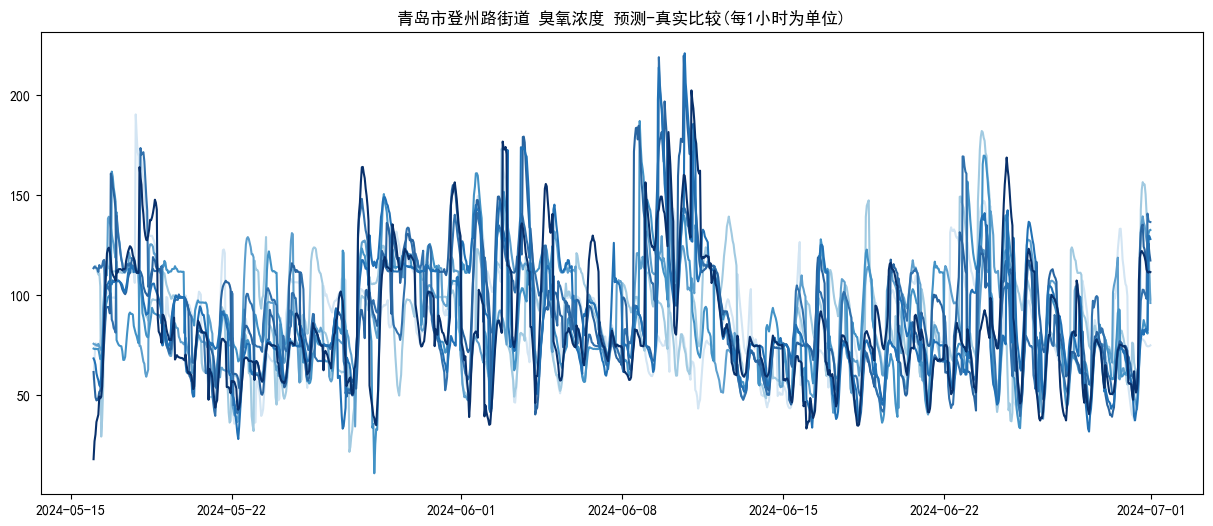

In [29]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import matplotlib.dates as mdates
from datetime import datetime, timedelta
date_range_list = []
start_date111 = datetime(2024, 5, 16, 0, 0, 0) 
end_date111 = datetime(2024, 6, 30, 23, 0, 0)
true_value_list = []
date_range111 = pd.date_range(start=start_date111, end=end_date111, freq='H')
merged_data = pd.merge(pd.DataFrame(date_range111, columns=['日期']), datat, on='日期', how='inner')

true_value_list = merged_data['O3VAL'].tolist()

start_date = datetime(2024, 5, 16, 0, 0, 0) 
end_date = datetime(2024, 5, 16, 23, 0, 0)
while end_date < datetime(2024, 7, 1, 0, 0, 0):
    date_range = pd.date_range(start=start_date, end=end_date, freq='H')
    date_range_list.append(date_range)
    end_date += timedelta(hours=1)
    start_date = end_date
    end_date += timedelta(days=1)
    end_date -= timedelta(hours=1)

num = 0
colors = [
 '#d3e5f3','#a1cae1', 
    '#5d9fcd', '#4292c6',  '#3171ad',
    '#2864a0', '#2171b5',   '#08306b','orange'
]
true_legend_added = 0 
pred_value_list_7 = np.array([])
pred_value_list_6 = np.array([])
pred_value_list_5 = np.array([])
pred_value_list_4 = np.array([])
pred_value_list_3 = np.array([])
pred_value_list_2 = np.array([])
pred_value_list_1 = np.array([])
pred_value_list_0 = np.array([])

for date_ranges in date_range_list:
    num = 7
    for i in range(len(df_list)):
        is_in_list = df_list[i]['日期'].isin(date_ranges)
        rmse_list = []
        r2_list = []
        if is_in_list.any():
            matching_indices = df_list[i].index[is_in_list].tolist()
            matching_values = df_list[i].loc[is_in_list, '日期'].tolist()
            if num == 7:
                pred_value_list_7 = np.concatenate((pred_value_list_7, y_pred_list[i][int(matching_indices[0]/5):int(matching_indices[-1]/5)+1]))
            elif num == 6:
                pred_value_list_6 = np.concatenate((pred_value_list_6, y_pred_list[i][int(matching_indices[0]/5):int(matching_indices[-1]/5)+1]))
            elif num == 5:
                pred_value_list_5 = np.concatenate((pred_value_list_5, y_pred_list[i][int(matching_indices[0]/5):int(matching_indices[-1]/5)+1]))
            elif num == 4:
                pred_value_list_4 = np.concatenate((pred_value_list_4, y_pred_list[i][int(matching_indices[0]/5):int(matching_indices[-1]/5)+1]))
            elif num == 3:
                pred_value_list_3 = np.concatenate((pred_value_list_3, y_pred_list[i][int(matching_indices[0]/5):int(matching_indices[-1]/5)+1]))
            elif num == 2:
                pred_value_list_2 = np.concatenate((pred_value_list_2, y_pred_list[i][int(matching_indices[0]/5):int(matching_indices[-1]/5)+1]))
            elif num == 1:
                pred_value_list_1 = np.concatenate((pred_value_list_1, y_pred_list[i][int(matching_indices[0]/5):int(matching_indices[-1]/5)+1]))
            elif num == 0:
                pred_value_list_0 = np.concatenate((pred_value_list_0, y_pred_list[i][int(matching_indices[0]/5):int(matching_indices[-1]/5)+1]))
            num-=1



plt.figure(figsize=(15, 6))
plt.title("青岛市登州路街道 臭氧浓度 预测-真实比较(每1小时为单位)")
plt.plot(date_range111,pred_value_list_7,color=colors[0], label='n-7')
plt.plot(date_range111,pred_value_list_6,color=colors[1], label='n-6')
plt.plot(date_range111,pred_value_list_5,color=colors[2], label='n-5')
plt.plot(date_range111,pred_value_list_4,color=colors[3], label='n-4')
plt.plot(date_range111,pred_value_list_3,color=colors[4], label='n-3')
plt.plot(date_range111,pred_value_list_2,color=colors[5], label='n-2')
plt.plot(date_range111,pred_value_list_1,color=colors[6], label='n-1')
plt.plot(date_range111,pred_value_list_0,color=colors[7], label='n-0')
plt.plot(date_range111,true_value_list,color=colors[-1], label='True')
plt.legend()
plt.show()   


print('n-7 MASE:',math.sqrt(mean_squared_error(true_value_list, pred_value_list_7)))
print('n-7 R2:',r2_score(true_value_list, pred_value_list_7))
print('n-6 MASE:',math.sqrt(mean_squared_error(true_value_list, pred_value_list_6)))
print('n-6 R2:',r2_score(true_value_list, pred_value_list_6))
print('n-5 MASE:',math.sqrt(mean_squared_error(true_value_list, pred_value_list_5)))
print('n-5 R2:',r2_score(true_value_list, pred_value_list_5))
print('n-4 MASE:',math.sqrt(mean_squared_error(true_value_list, pred_value_list_4)))
print('n-4 R2:',r2_score(true_value_list, pred_value_list_4))
print('n-3 MASE:',math.sqrt(mean_squared_error(true_value_list, pred_value_list_3)))
print('n-3 R2:',r2_score(true_value_list, pred_value_list_3))
print('n-2 MASE:',math.sqrt(mean_squared_error(true_value_list, pred_value_list_2)))
print('n-2 R2:',r2_score(true_value_list, pred_value_list_2))
print('n-1 MASE:',math.sqrt(mean_squared_error(true_value_list, pred_value_list_1)))
print('n-1 R2:',r2_score(true_value_list, pred_value_list_1))
print('n-0 MASE:',math.sqrt(mean_squared_error(true_value_list, pred_value_list_0)))
print('n-0 R2:',r2_score(true_value_list, pred_value_list_0))
# r2_list.append(r2_score(y_list[i].values[int(matching_indices[0]/5):int(matching_indices[(j+1)*24-1]/5)+1], y_pred_list[i][int(matching_indices[0]/5):int(matching_indices[(j+1)*24-1]/5)+1]))
# print(f"第{num}条线,前{j+1}天 rmse:", rmse_list[j])
# print(f"第{num}条线,前{j+1}天 r2 score:", r2_list[j])

In [30]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

rmse_list = []
r2_list = []

for i in range(46):
    mase7 = math.sqrt(mean_squared_error(true_value_list[i*24:i*24+24], pred_value_list_7[i*24:i*24+24]))
    mase6 = math.sqrt(mean_squared_error(true_value_list[i*24:i*24+24], pred_value_list_6[i*24:i*24+24]))
    mase5 = math.sqrt(mean_squared_error(true_value_list[i*24:i*24+24], pred_value_list_5[i*24:i*24+24]))
    mase4 = math.sqrt(mean_squared_error(true_value_list[i*24:i*24+24], pred_value_list_4[i*24:i*24+24]))
    mase3 = math.sqrt(mean_squared_error(true_value_list[i*24:i*24+24], pred_value_list_3[i*24:i*24+24]))
    mase2 = math.sqrt(mean_squared_error(true_value_list[i*24:i*24+24], pred_value_list_2[i*24:i*24+24]))
    mase1 = math.sqrt(mean_squared_error(true_value_list[i*24:i*24+24], pred_value_list_1[i*24:i*24+24]))
    mase0 = math.sqrt(mean_squared_error(true_value_list[i*24:i*24+24], pred_value_list_0[i*24:i*24+24]))
    r27 = r2_score(true_value_list[i*24:i*24+24], pred_value_list_7[i*24:i*24+24])
    r26 = r2_score(true_value_list[i*24:i*24+24], pred_value_list_6[i*24:i*24+24])
    r25 = r2_score(true_value_list[i*24:i*24+24], pred_value_list_5[i*24:i*24+24])
    r24 = r2_score(true_value_list[i*24:i*24+24], pred_value_list_4[i*24:i*24+24])
    r23 = r2_score(true_value_list[i*24:i*24+24], pred_value_list_3[i*24:i*24+24])
    r22 = r2_score(true_value_list[i*24:i*24+24], pred_value_list_2[i*24:i*24+24])
    r21 = r2_score(true_value_list[i*24:i*24+24], pred_value_list_1[i*24:i*24+24])
    r20 = r2_score(true_value_list[i*24:i*24+24], pred_value_list_0[i*24:i*24+24])
    rmse_list.append(mase7)
    rmse_list.append(mase6)
    rmse_list.append(mase5)
    rmse_list.append(mase4)
    rmse_list.append(mase3)
    rmse_list.append(mase2)
    rmse_list.append(mase1)
    rmse_list.append(mase0)
    std_dev1 = np.std(rmse_list)
    r2_list.append(r27)
    r2_list.append(r26)
    r2_list.append(r25)
    r2_list.append(r24)
    r2_list.append(r23)
    r2_list.append(r22)
    r2_list.append(r21)
    r2_list.append(r20)
    std_dev2 = np.std(r2_list)
    col_name1 = 'rmse'
    col_name2 = 'r2'

df = pd.DataFrame({
    'rmse': rmse_list,
    'r2': r2_list
})

# 将 DataFrame 写入 CSV 文件
df.to_csv('metrics_dezhou.csv', index=False)

ValueError: Found input variables with inconsistent numbers of samples: [23, 24]

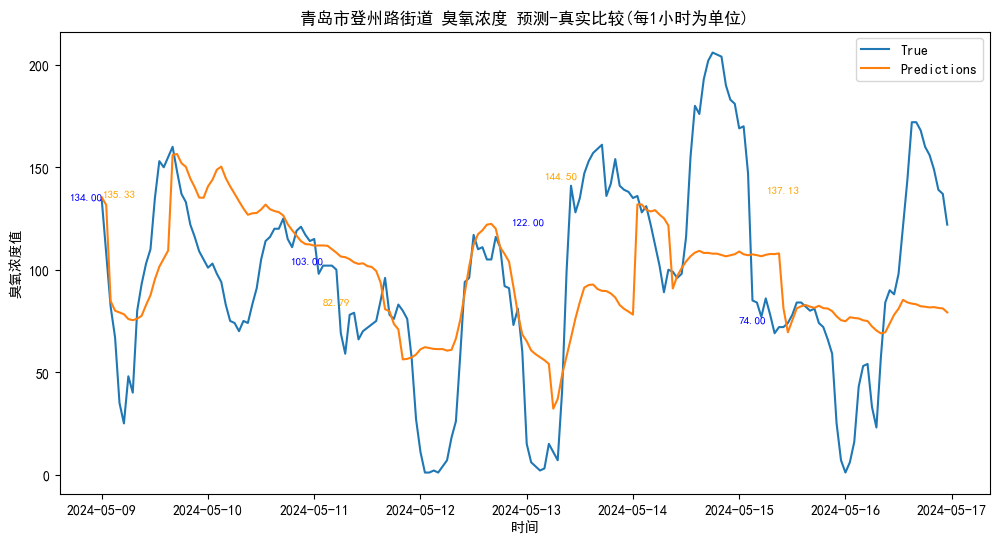

rmse: 42.39464172032049
r2 score: 0.23605659585643268


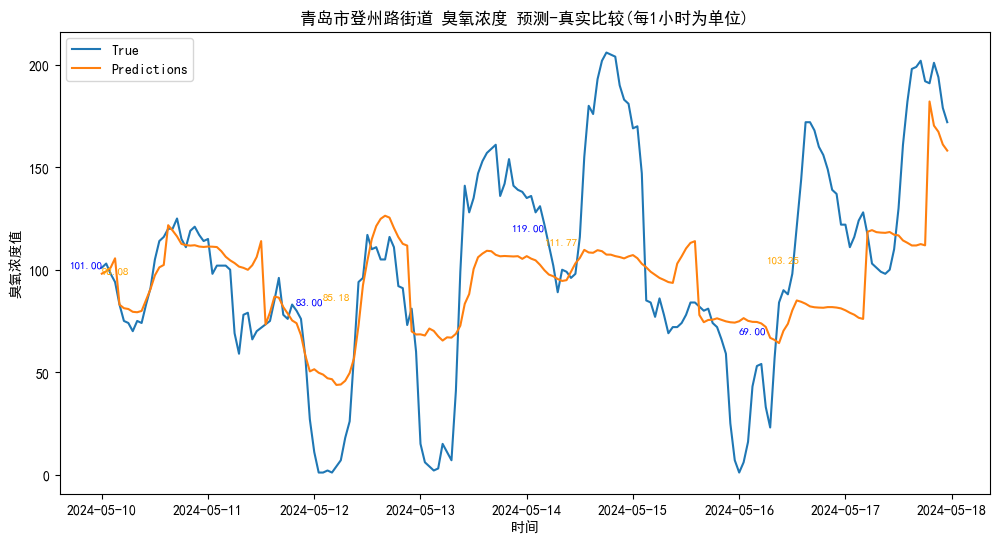

rmse: 40.29467943071356
r2 score: 0.385903501867749


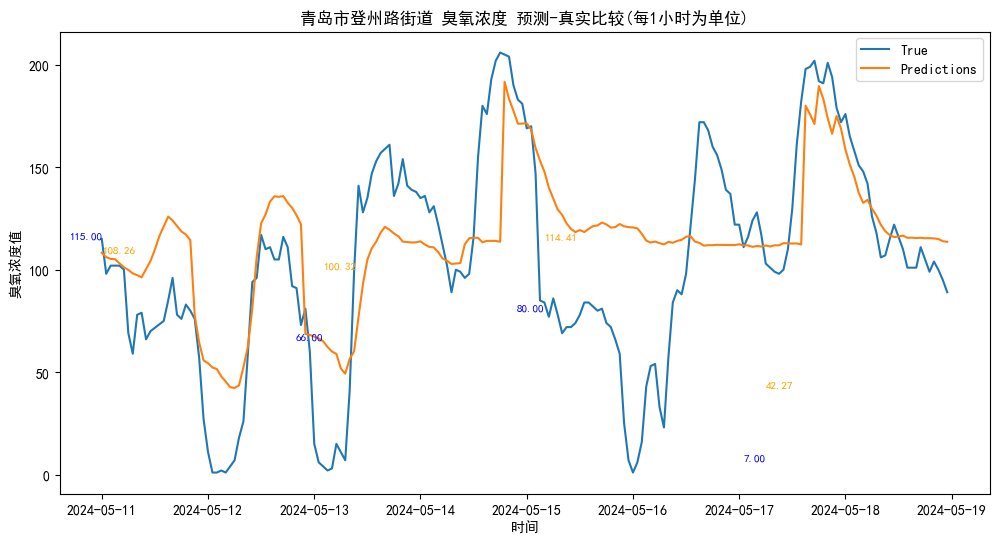

rmse: 39.466779142094616
r2 score: 0.42537751019083125


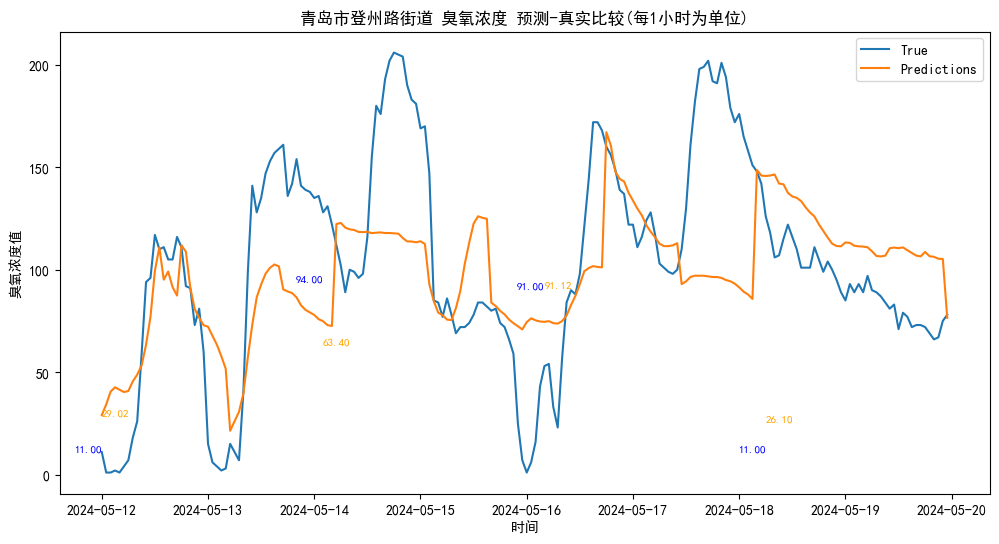

rmse: 43.889527249418094
r2 score: 0.27993946935143


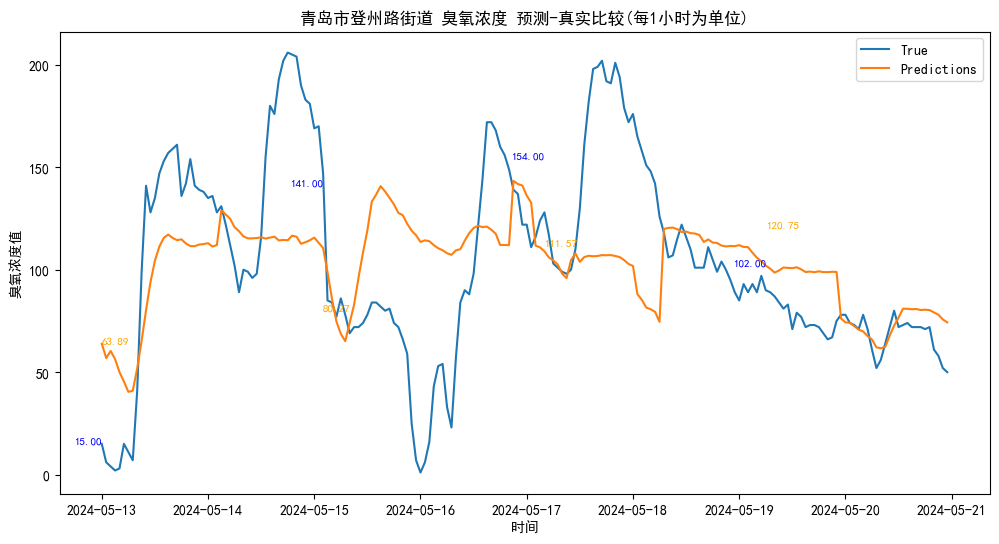

rmse: 43.90041894288367
r2 score: 0.1896938087990715


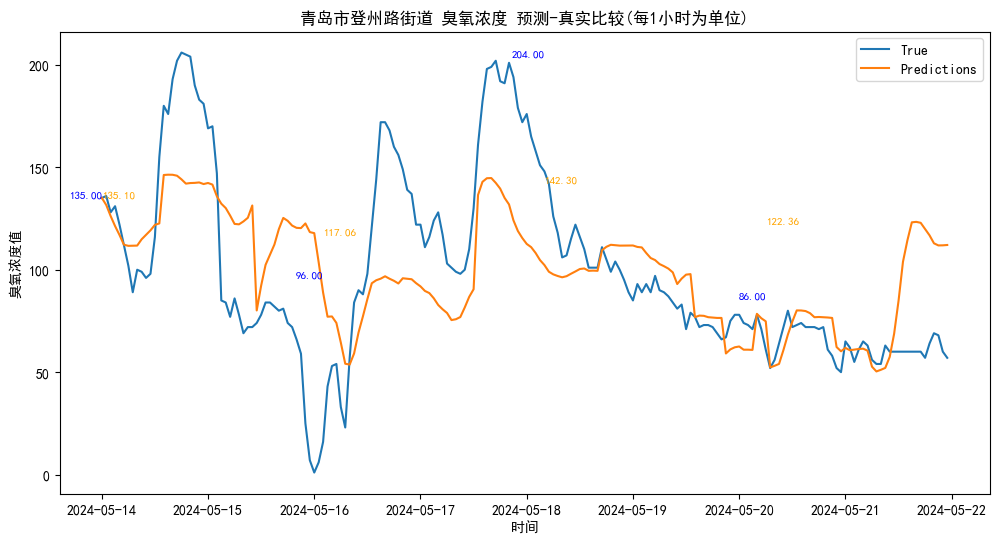

rmse: 37.014924584466186
r2 score: 0.33619543923587625


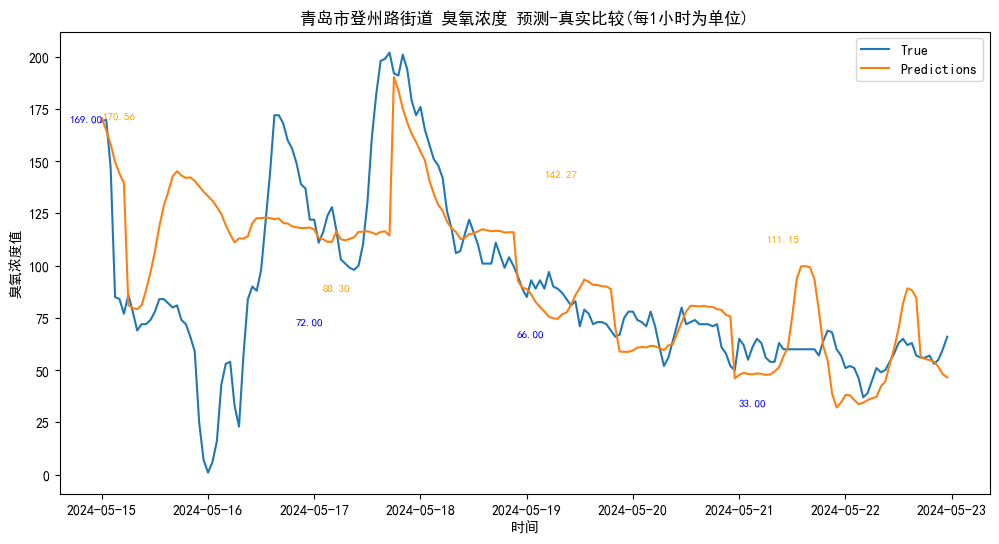

rmse: 34.69504645744348
r2 score: 0.2958634027593786


rmse: 26.343754785233912
r2 score: 0.5579278165006676


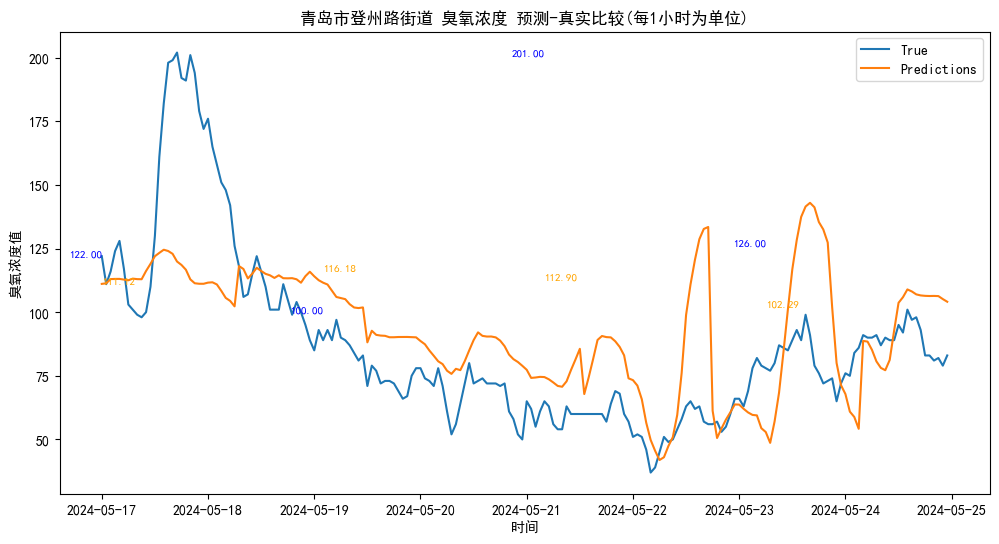

rmse: 28.819480350168433
r2 score: 0.2932905171634618


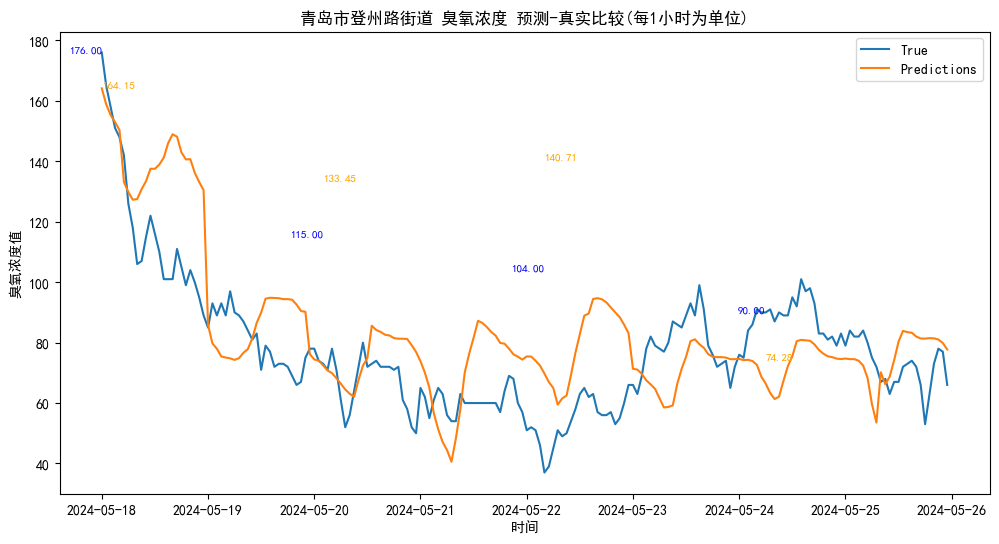

rmse: 18.79926133727015
r2 score: 0.2555143979565573


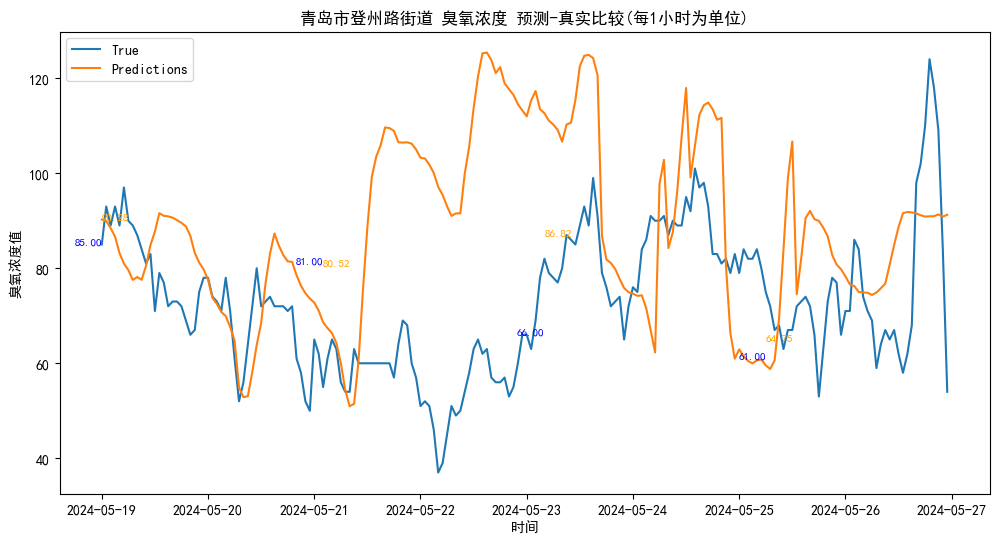

rmse: 27.982020861673448
r2 score: -2.6950908102215863


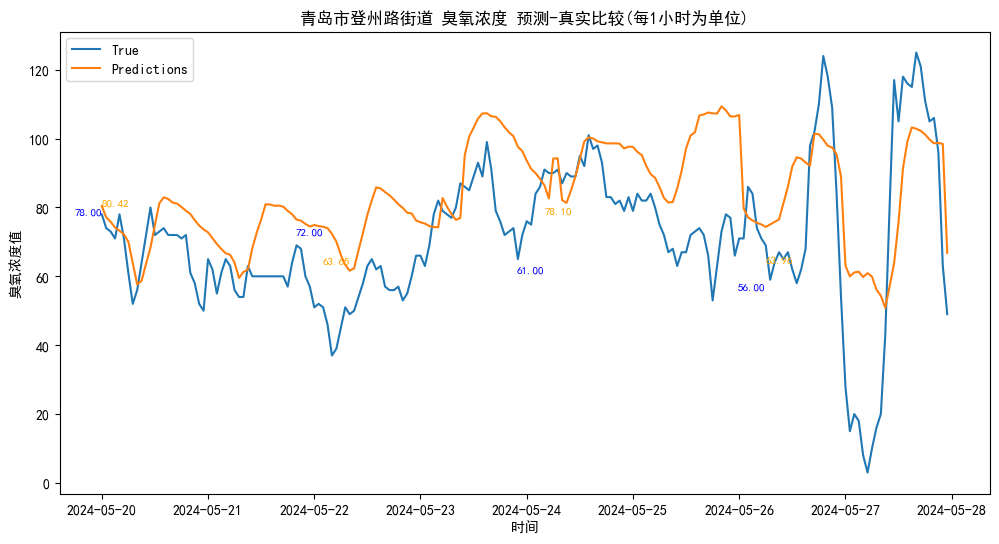

rmse: 20.871469160401453
r2 score: 0.03177926620126126


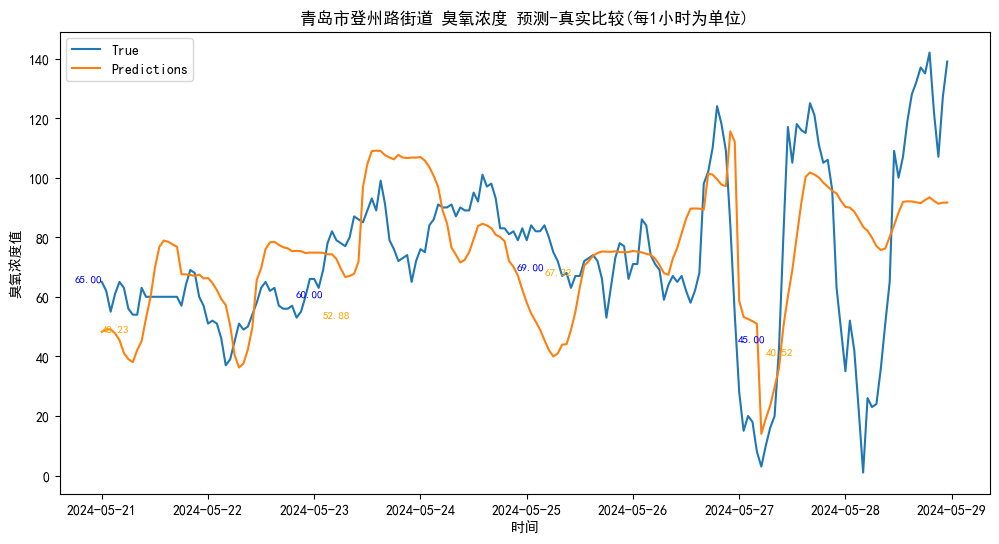

rmse: 23.879414806549622
r2 score: 0.21651591311227036


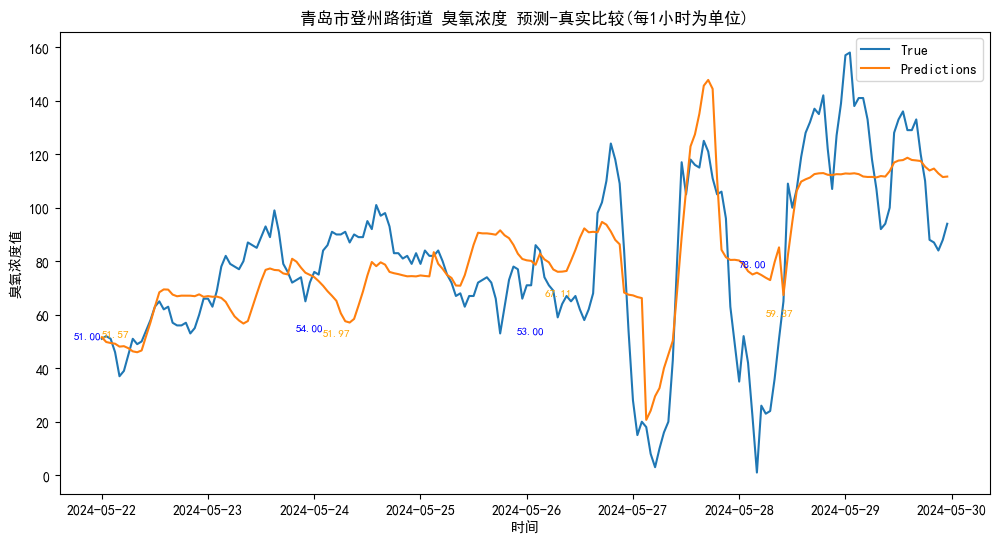

rmse: 20.82320711920444
r2 score: 0.5559942981111479


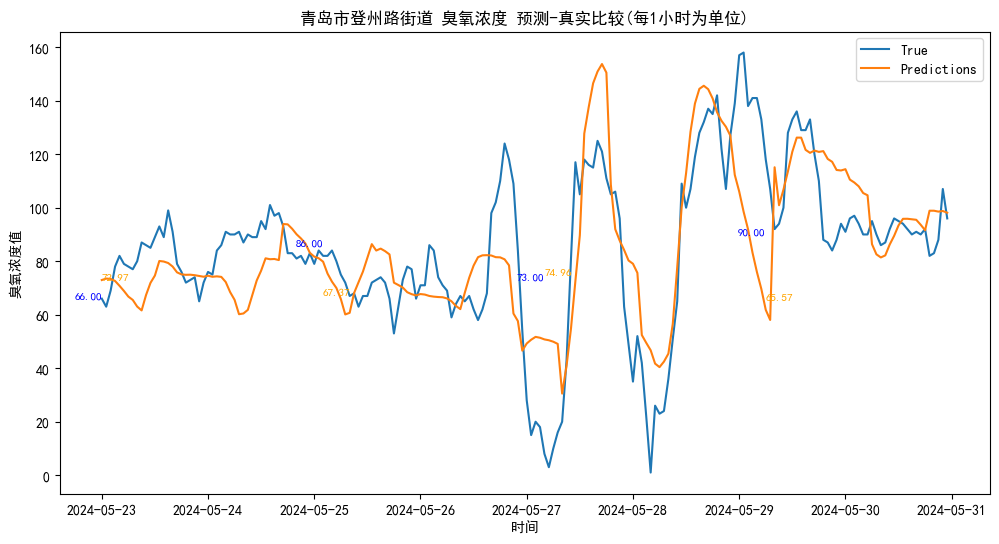

rmse: 21.188661103985748
r2 score: 0.491742607448435


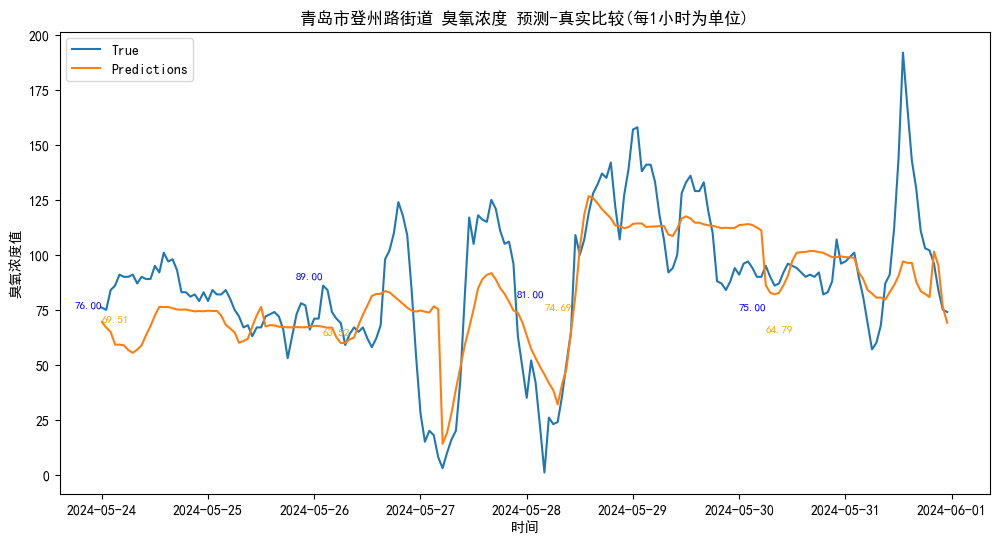

rmse: 22.69572421638709
r2 score: 0.4996030456417948


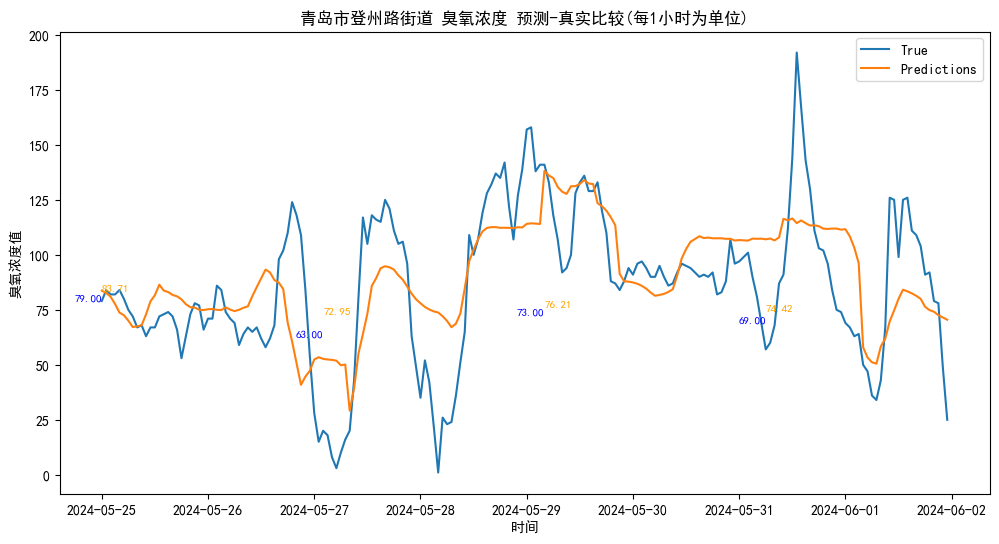

rmse: 26.151541418919017
r2 score: 0.40849840344445565


rmse: 32.58768862597856
r2 score: 0.30661586673973806


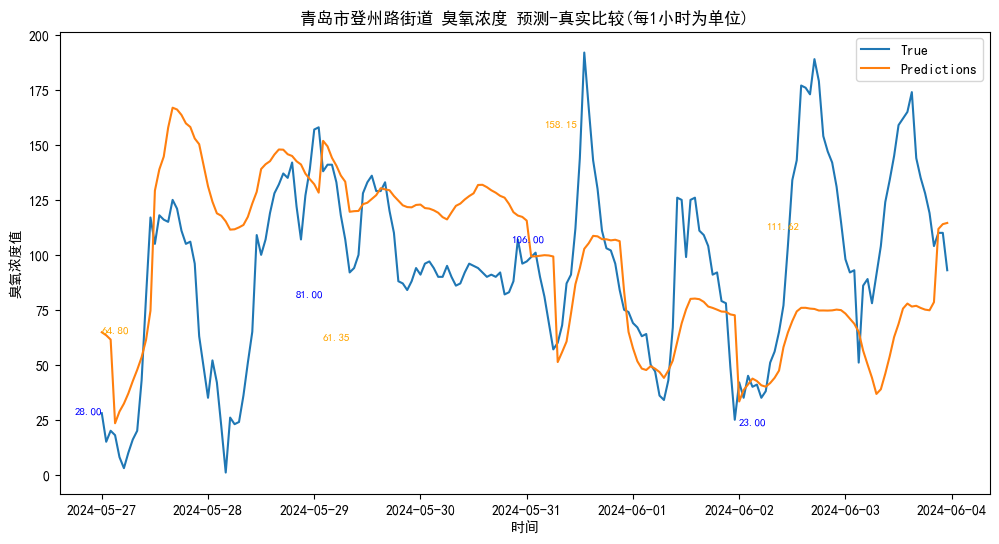

rmse: 44.177673320385146
r2 score: -0.18611895807289103


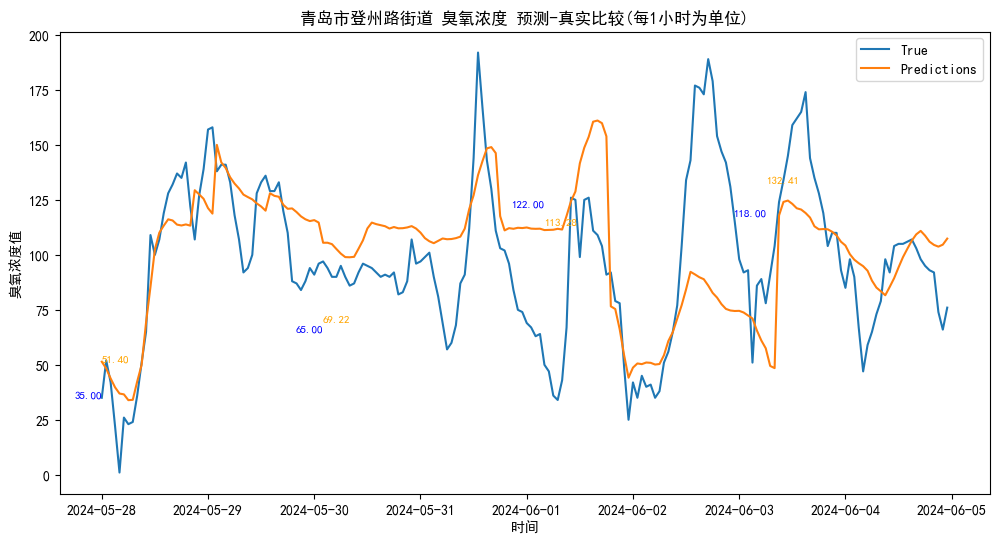

rmse: 31.74819806735808
r2 score: 0.24317863116892946


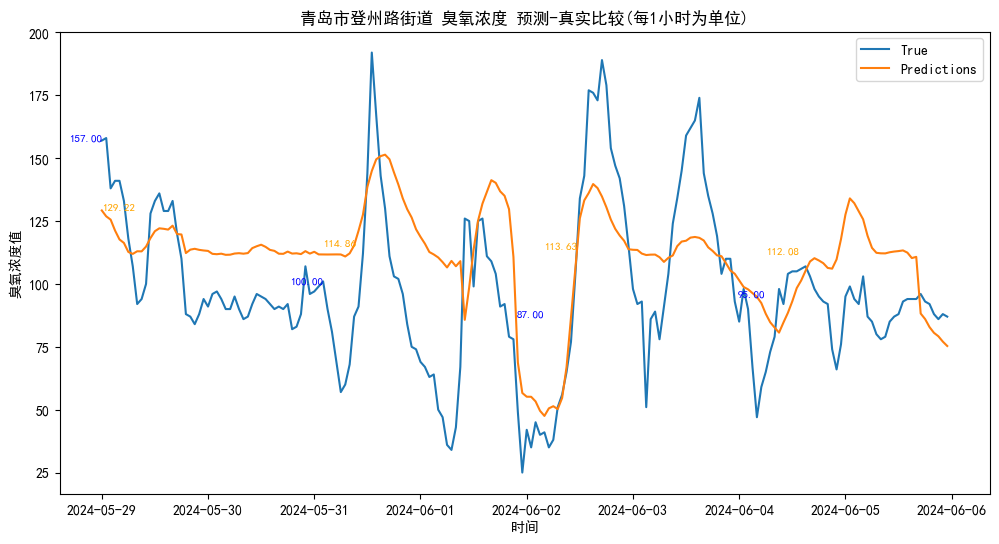

rmse: 28.436809217355925
r2 score: 0.22250632443762042


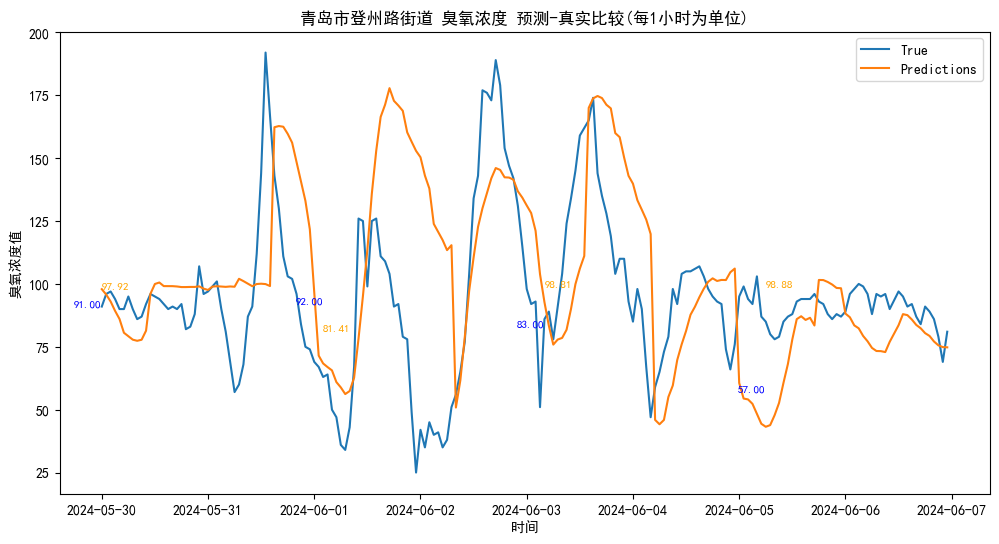

rmse: 37.627532791501075
r2 score: -0.5253575682251479


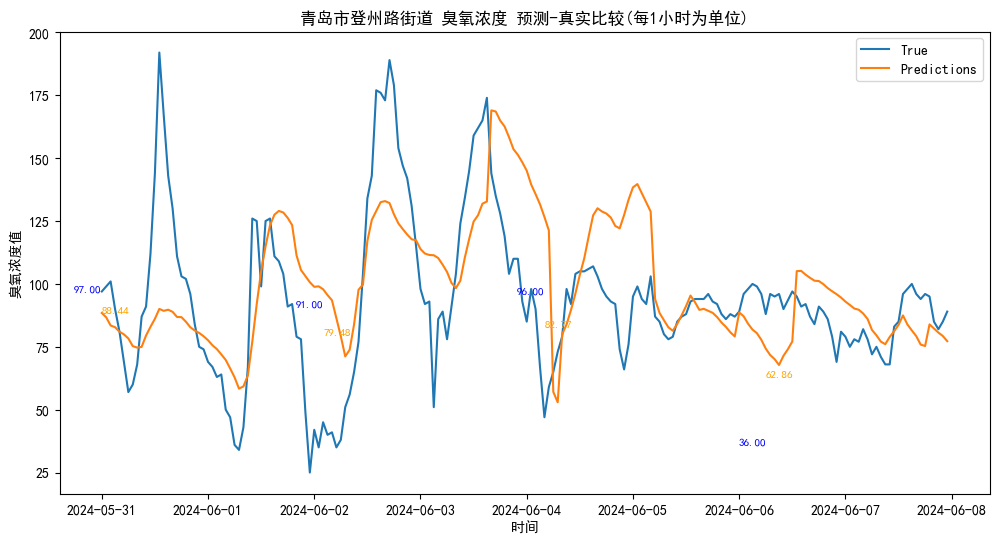

rmse: 29.63623875353052
r2 score: 0.07583000644191706


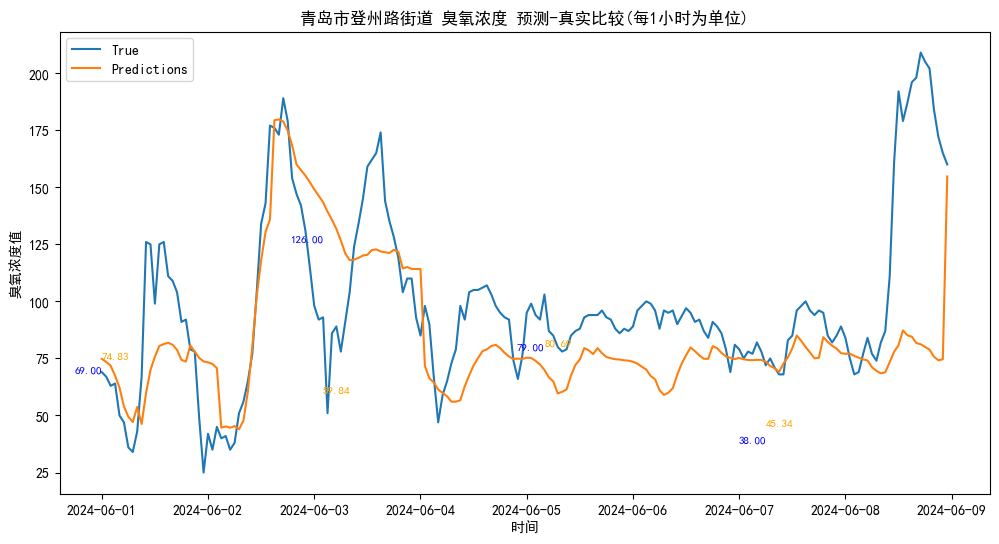

rmse: 35.176346423364286
r2 score: 0.11131576048229674


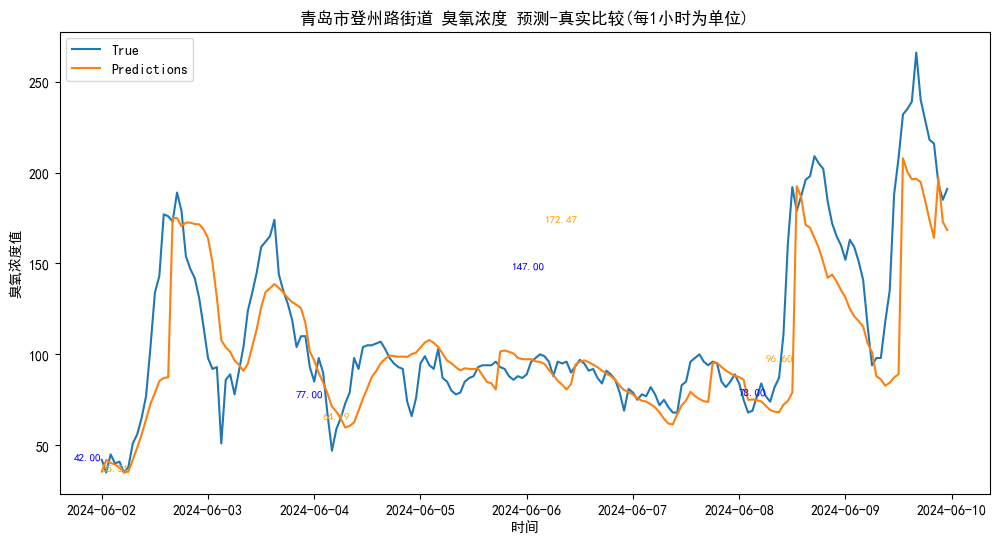

rmse: 28.171907534541866
r2 score: 0.6346218289525406


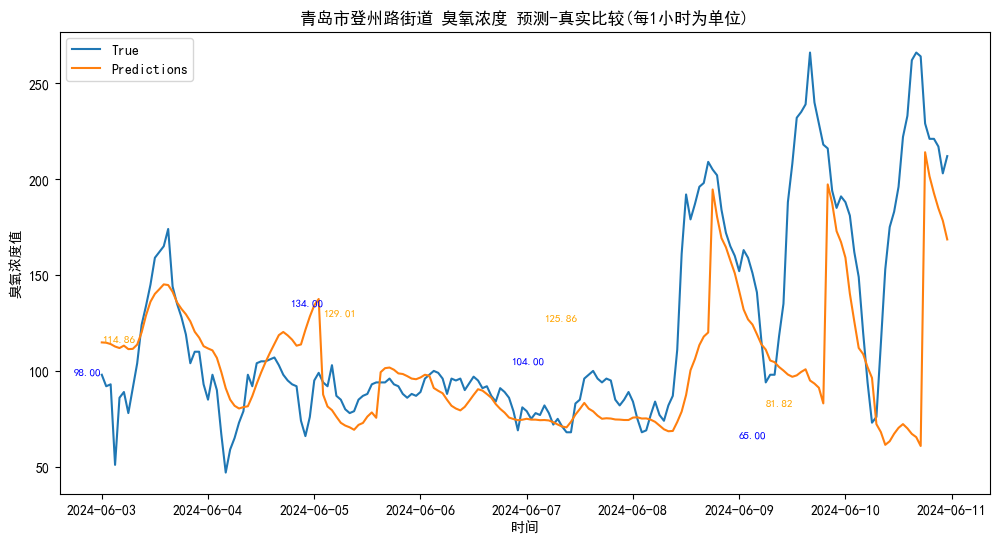

rmse: 50.70663046021041
r2 score: 0.06034873280726705


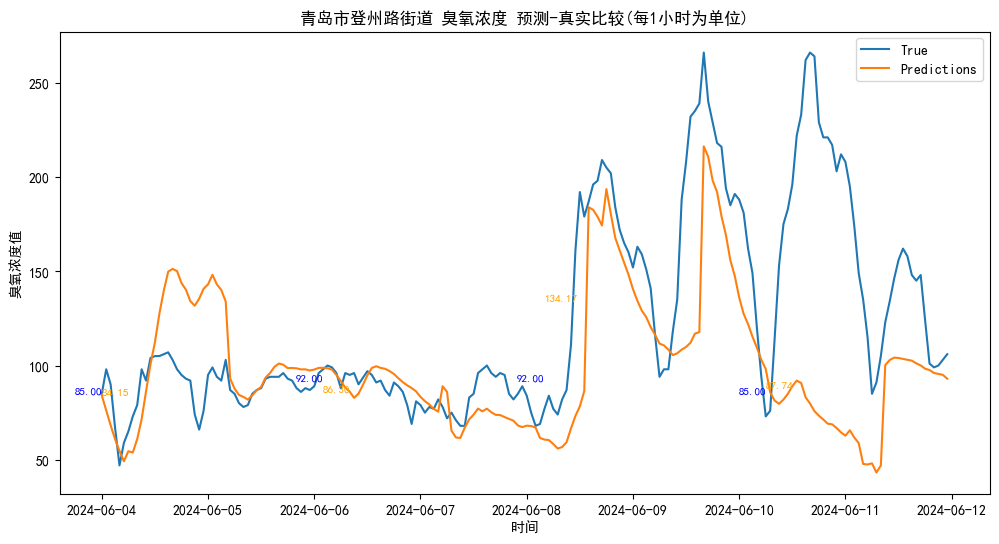

rmse: 54.584489043717326
r2 score: -0.07954987098913735


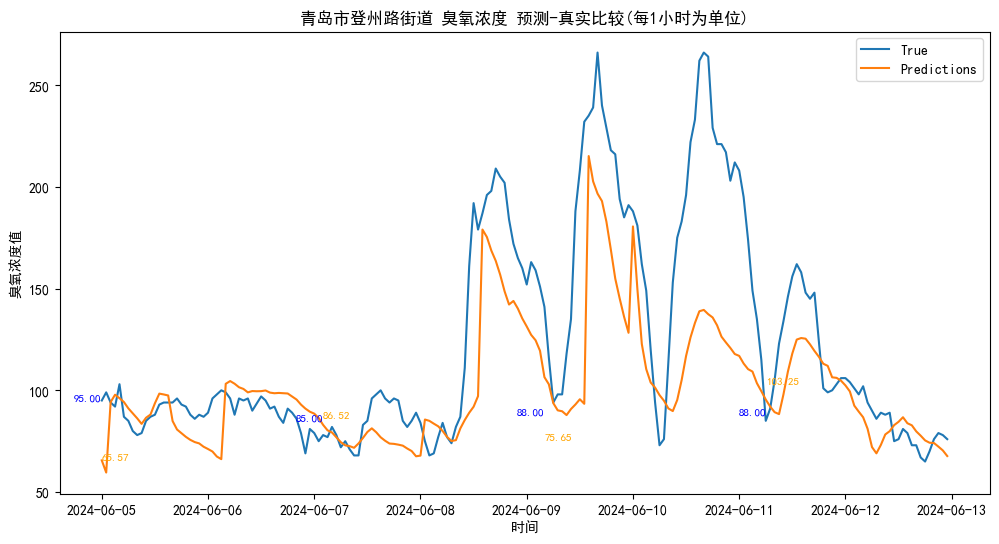

rmse: 39.767125067639086
r2 score: 0.4283789516885441


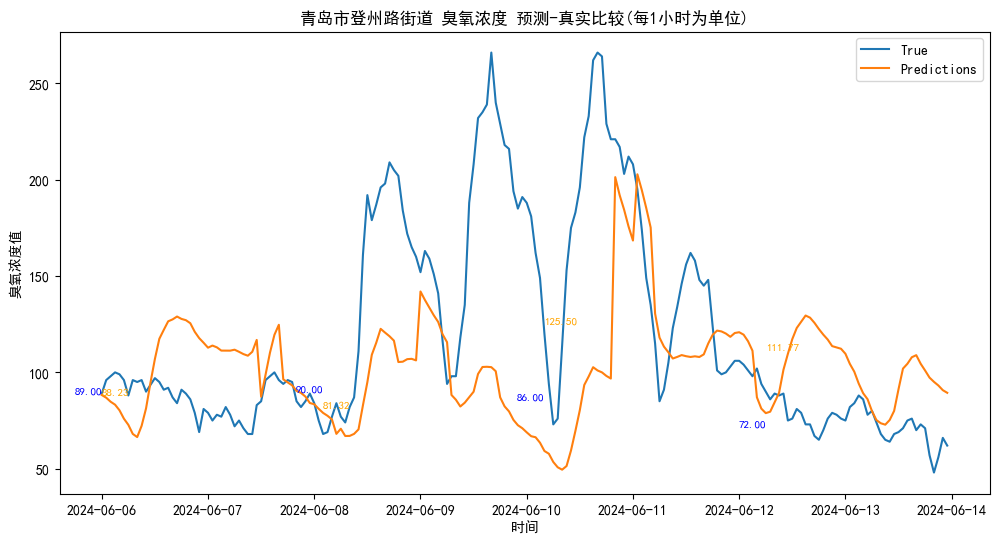

rmse: 59.01902132627324
r2 score: -0.17446699700923562


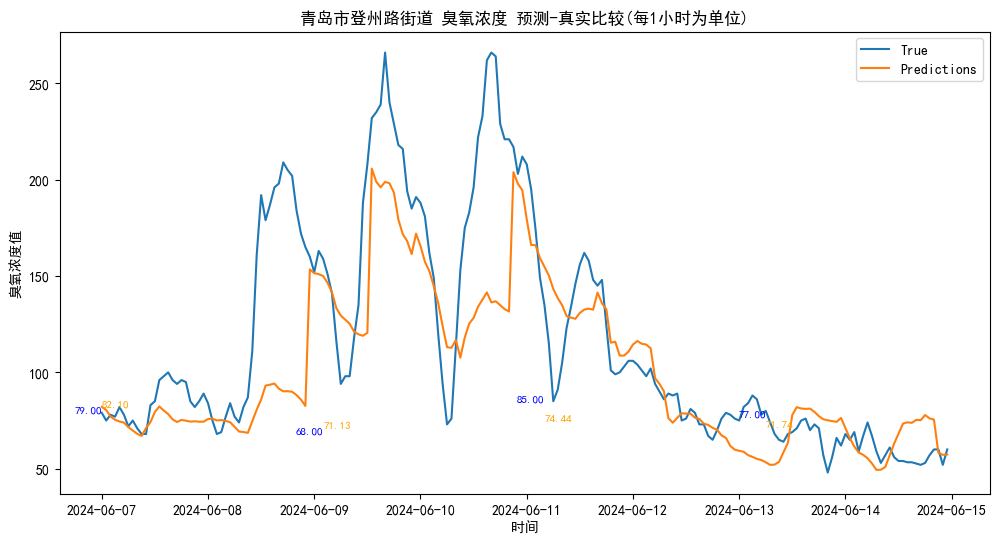

rmse: 39.06666302708628
r2 score: 0.5387205083597009


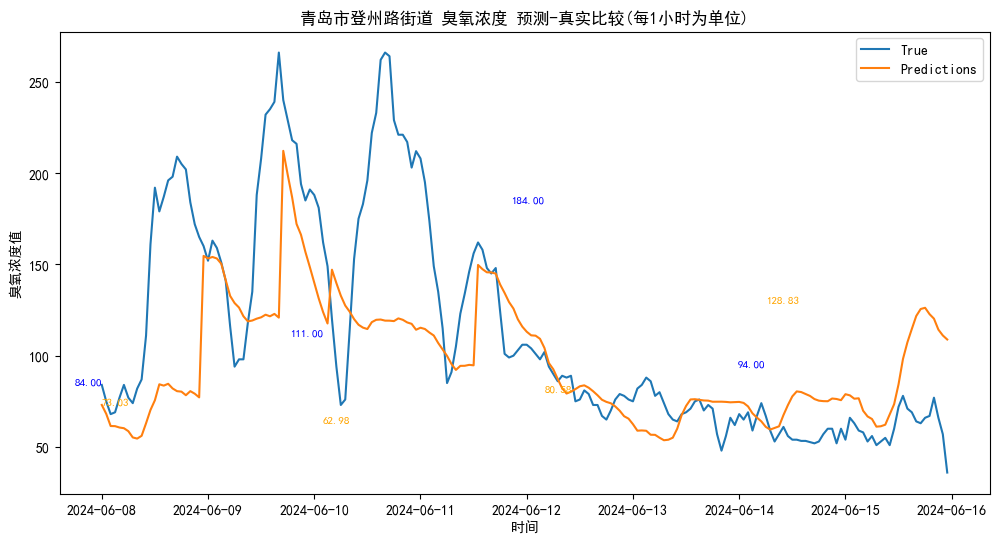

rmse: 50.46387305581577
r2 score: 0.2822069765890953


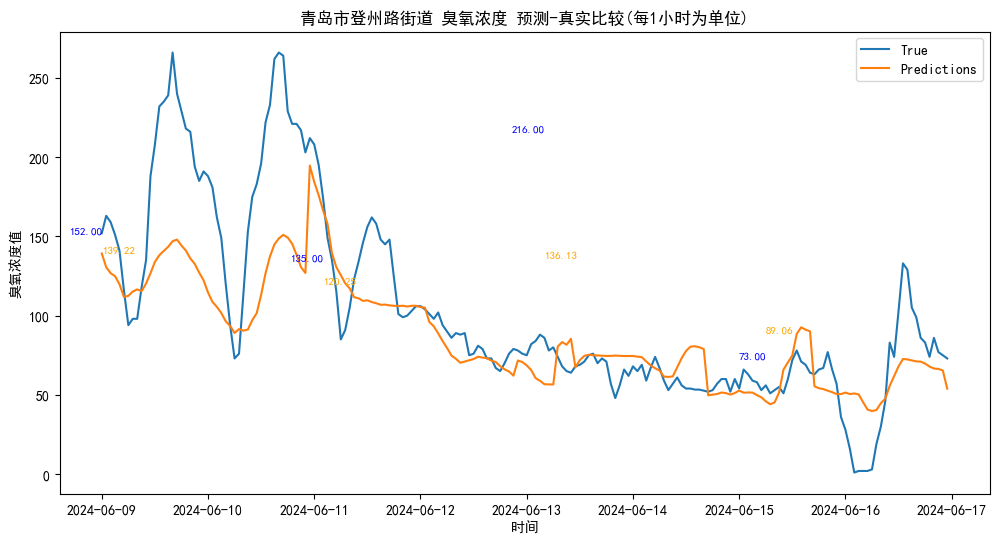

rmse: 38.63195907997552
r2 score: 0.5850571844994432


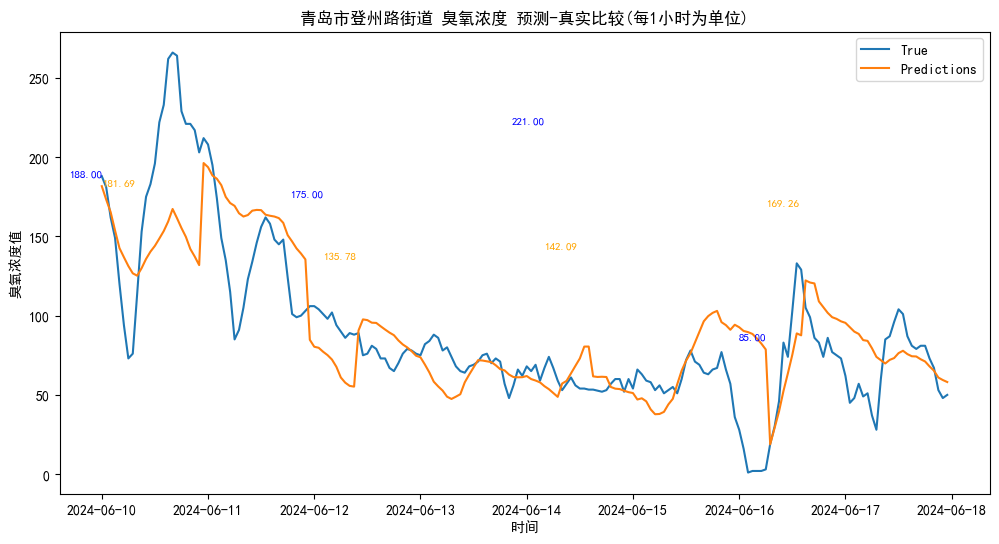

rmse: 34.155462482201344
r2 score: 0.5553440131068303


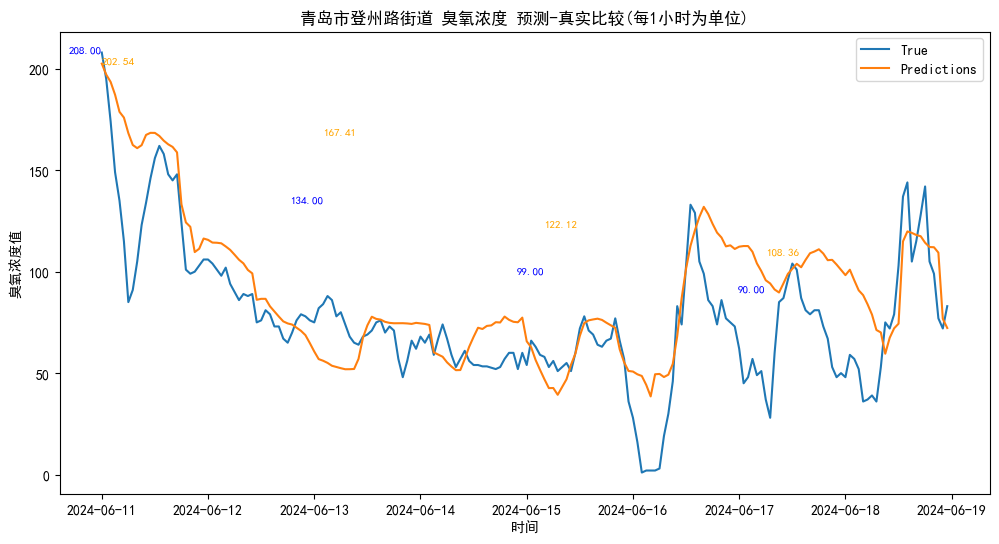

rmse: 26.517206257791734
r2 score: 0.374237373699315


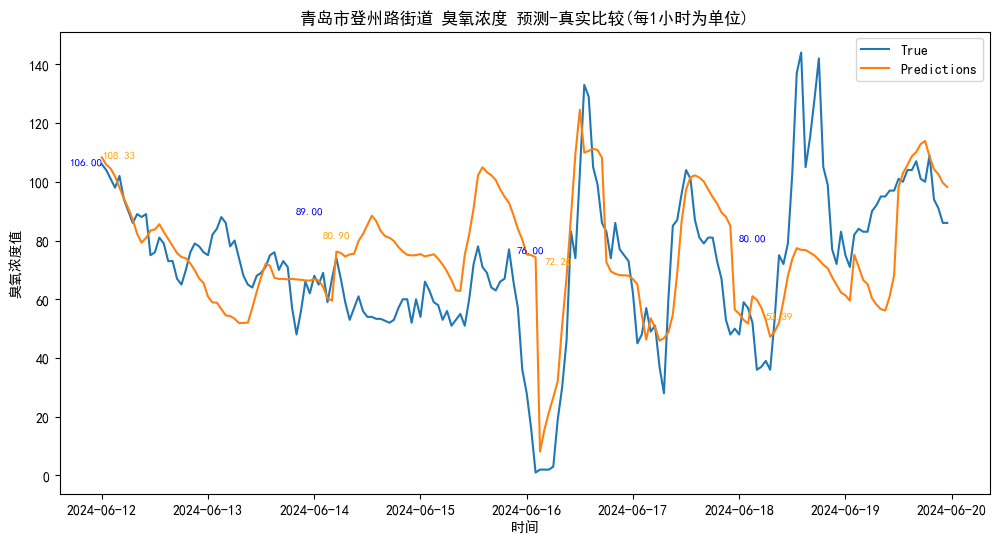

rmse: 21.65294486878763
r2 score: 0.2337919267068429


rmse: 23.979500619586155
r2 score: 0.11706588855273603


rmse: 23.563929924385743
r2 score: 0.1506724895348539


rmse: 31.752795029955667
r2 score: -0.1279627901269964


rmse: 32.247529266319226
r2 score: 0.15872524087470874


rmse: 31.93684176918642
r2 score: -0.046998415011011874


rmse: 29.347853217889785
r2 score: 0.0658247673326321


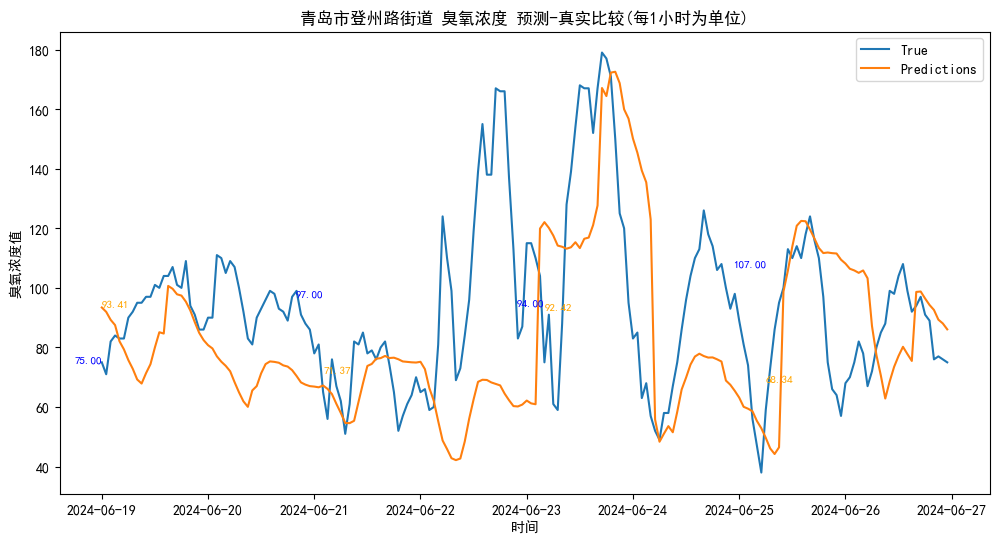

rmse: 33.23942197316527
r2 score: -0.4088781854024306


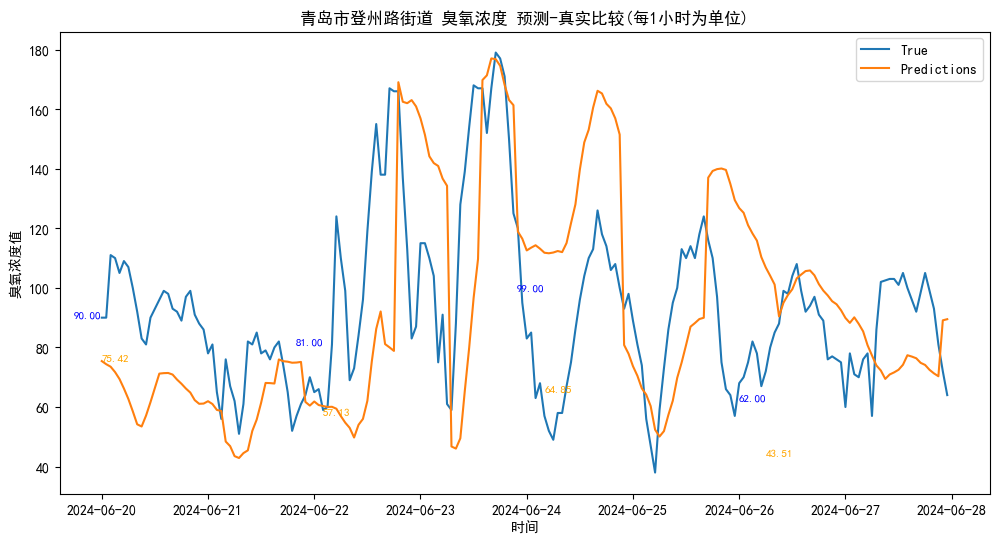

rmse: 36.23370611674685
r2 score: -0.6268037985947326


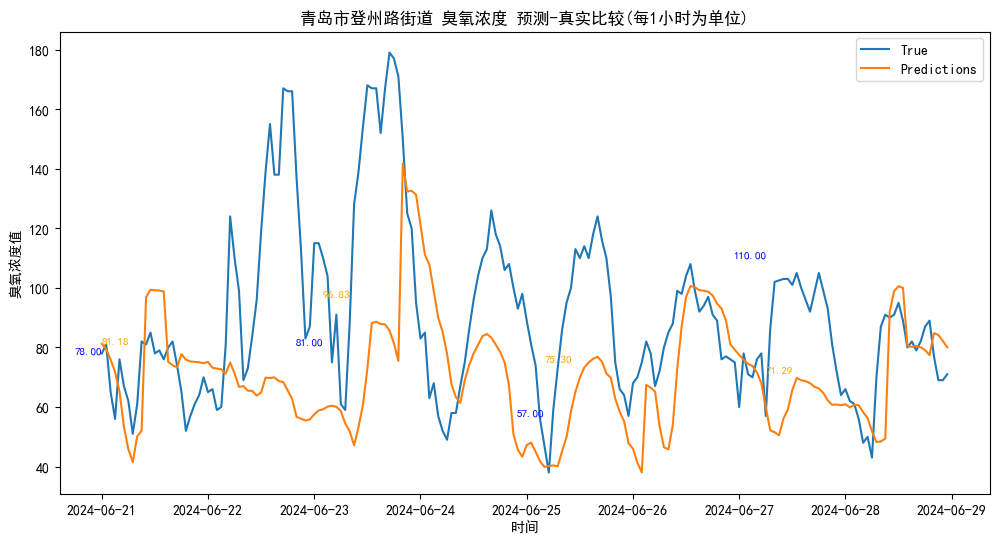

rmse: 36.871386744626776
r2 score: -0.5733776198317473


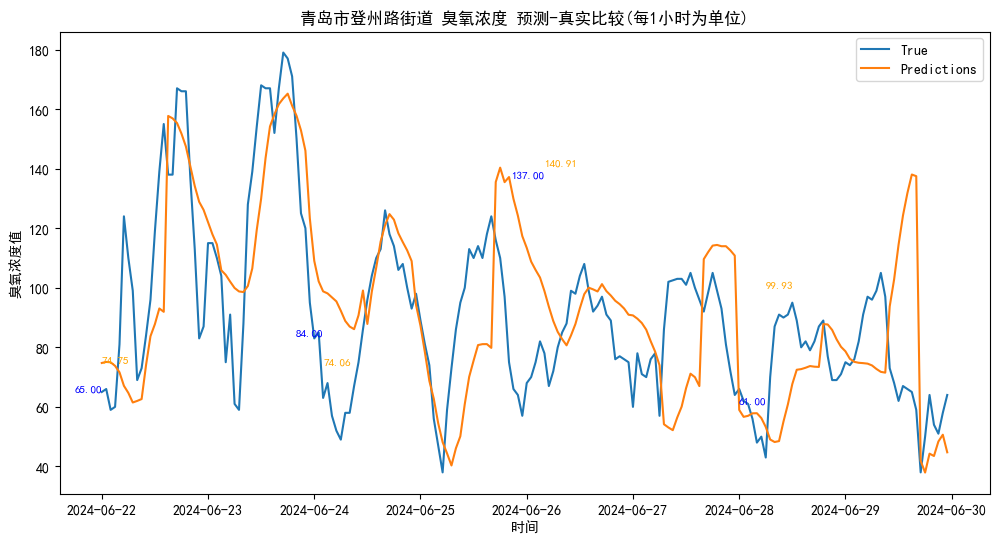

rmse: 27.481486168985512
r2 score: 0.1406491095158383


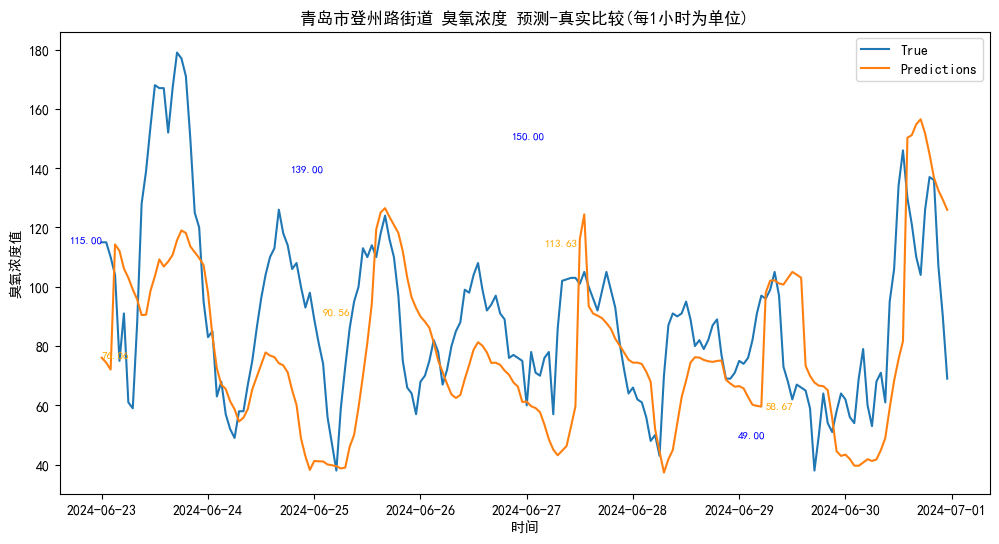

rmse: 29.117947959260377
r2 score: -0.06050099201052883


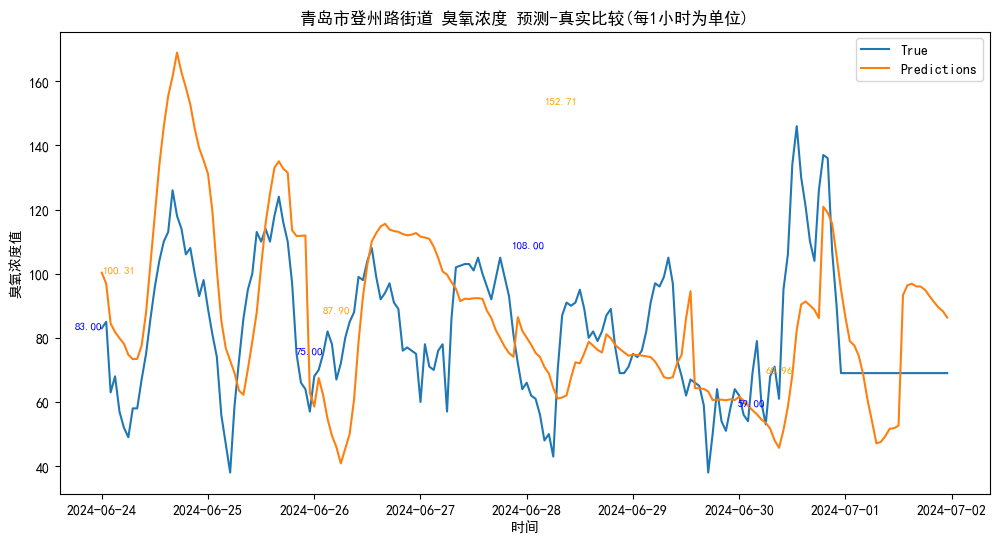

rmse: 24.19798114322658
r2 score: -0.33864740399451887


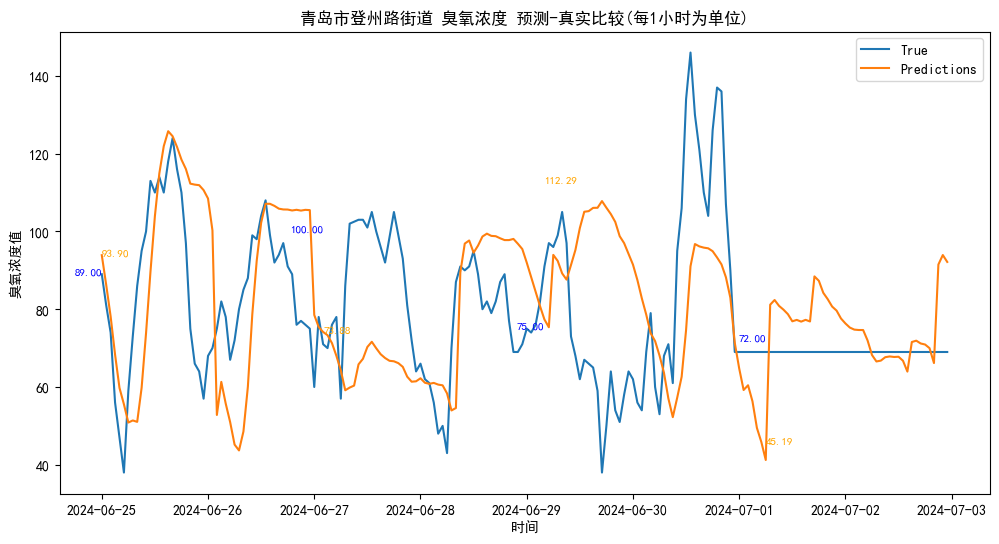

rmse: 23.40376913633744
r2 score: -0.42793177995689446


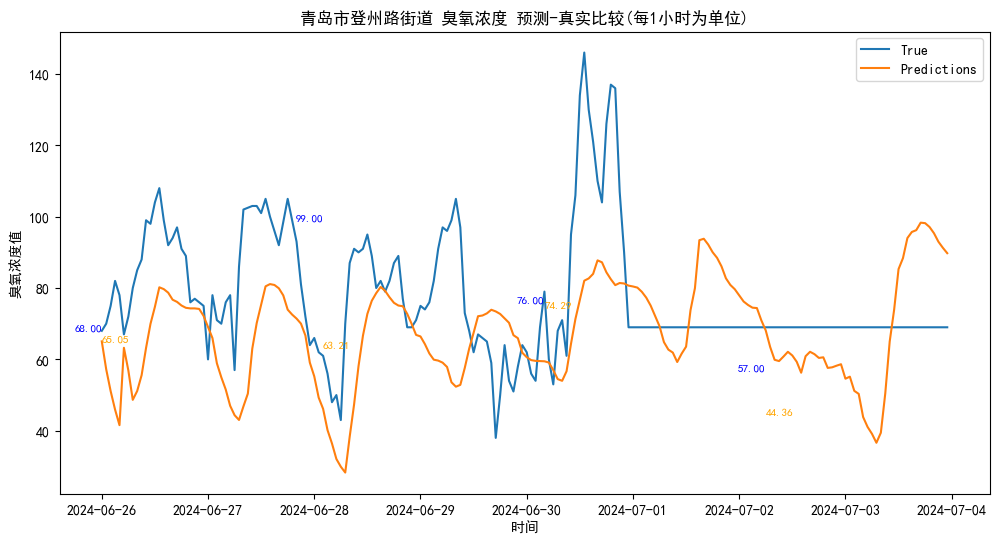

rmse: 22.438569499873715
r2 score: -0.6199837453672523


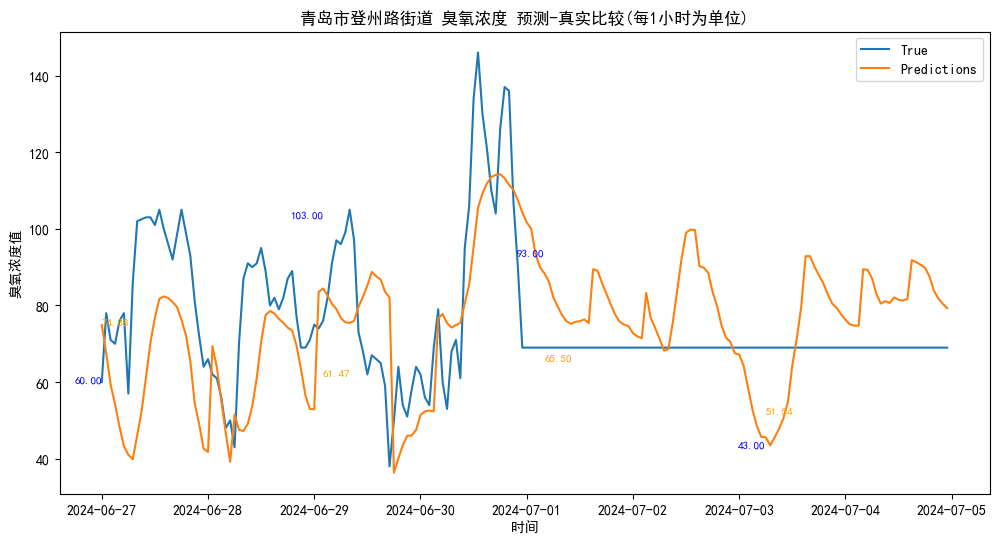

rmse: 19.142727522232324
r2 score: -0.25846006589160453


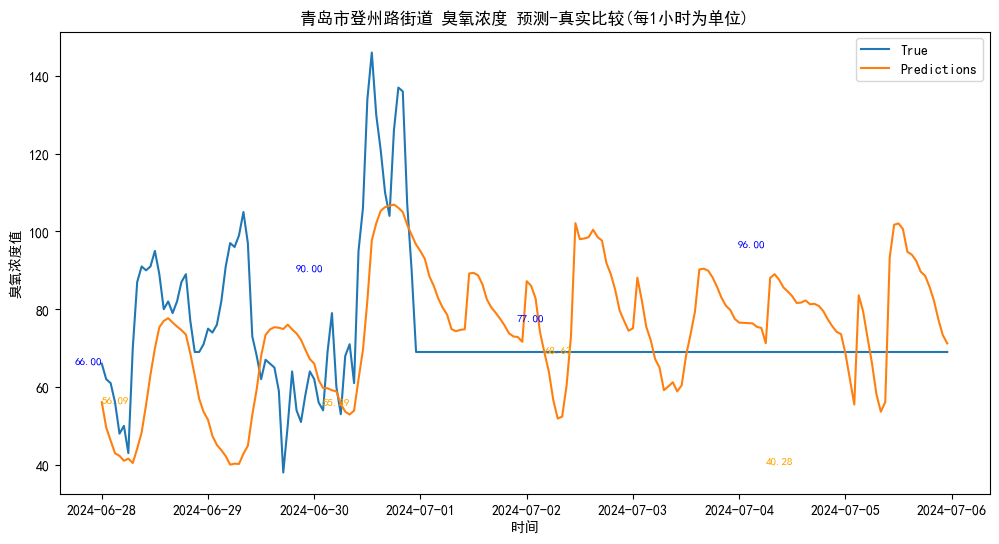

rmse: 20.09526438371561
r2 score: -0.6535075316743413


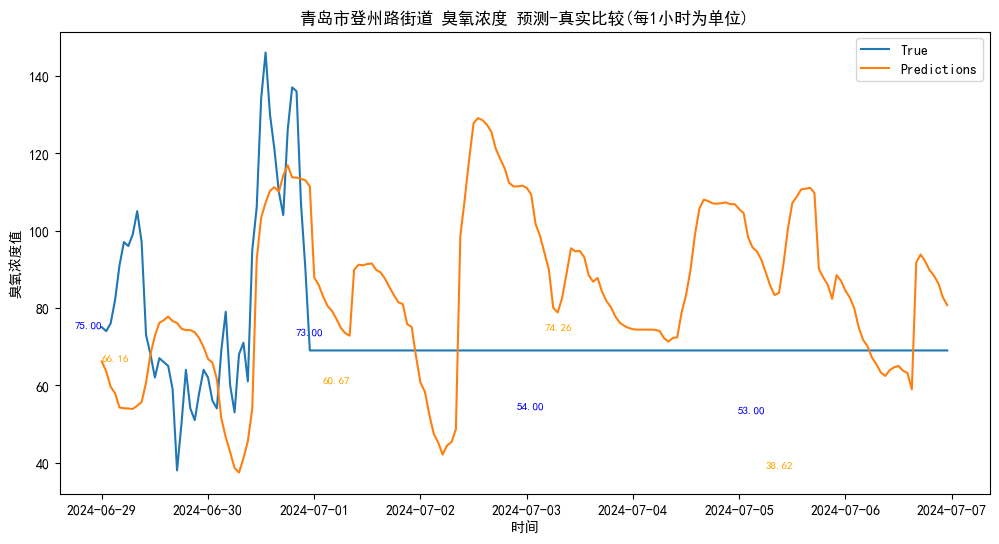

rmse: 25.572304716418785
r2 score: -1.9944735236660542


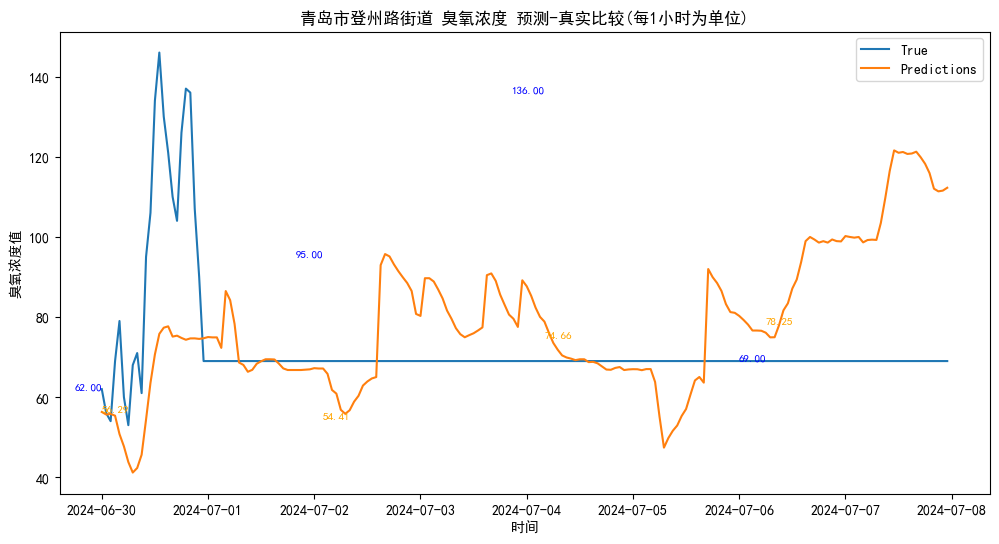

rmse: 23.288191559483312
r2 score: -1.9814891602307343


In [ ]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
for i in range(len(df_list)):
# 绘制真实值和预测值的曲线
    plt.figure(figsize=(12, 6))
    plt.title("青岛市登州路街道 臭氧浓度 预测-真实比较(每1小时为单位)")
    plt.plot(df_list[i]['日期'],y_list[i].values , label='True')
    plt.plot(df_list[i]['日期'],y_pred_list[i] , label='Predictions')
    plt.xlabel('时间')
    plt.ylabel('臭氧浓度值')

# 显示每个具体的数值
    for j in range(0, len(df_list[i]), 10):
        if 5 * j < len(df_list[i]):
            plt.text(df_list[i].iloc[5*j]['日期'], y_list[i].values[j], f'{y_list[i].values[j]:.2f}', color='blue', fontsize=8, ha='right')
            plt.text(df_list[i].iloc[5*j]['日期'], y_pred_list[i][j], f'{y_pred_list[i][j]:.2f}', color='orange', fontsize=8, ha='left')
    plt.legend()
    plt.show()
    print("rmse:", math.sqrt(mean_squared_error(y_list[i].values, y_pred_list[i])))
    print("r2 score:", r2_score(y_list[i].values, y_pred_list[i]))
    print("all")
    print("rmse:", math.sqrt(mean_squared_error(y_list[i].values, y_pred_list[i])))
    print("r2 score:", r2_score(y_list[i].values, y_pred_list[i]))
    print("all-1")
    print("rmse:", math.sqrt(mean_squared_error(y_list[i].values[:-(2*24)], y_pred_list[i][:-(2*24)])))
    print("r2 score:", r2_score(y_list[i].values[:-(2*24)], y_pred_list[i][:-(2*24)]))
    print("all-2")
    print("rmse:", math.sqrt(mean_squared_error(y_list[i].values[:-(3 *24)], y_pred_list[i][:-(3 *24)])))
    print("r2 score:", r2_score(y_list[i].values[:-(3 *24)], y_pred_list[i][:-(3 *24)]))

KeyError: 0

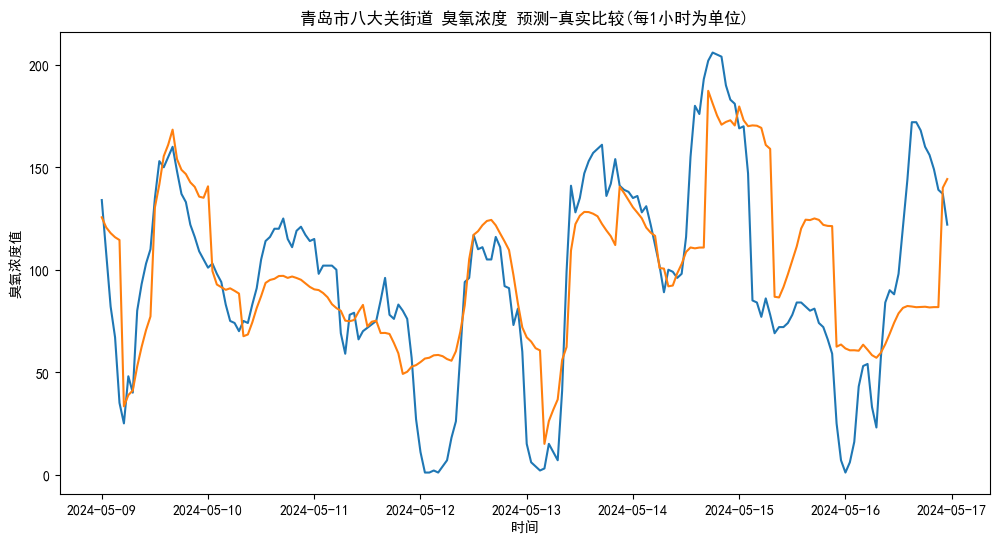

In [ ]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
for i in range(len(df_list)):
# 绘制真实值和预测值的曲线
    plt.figure(figsize=(12, 6))
    plt.title("青岛市八大关街道 臭氧浓度 预测-真实比较(每1小时为单位)")
    plt.plot(df_list[i]['日期'],y_list[i].values , label='True')
    plt.plot(df_list[i]['日期'],y_pred_list[i] , label='Predictions')
    plt.xlabel('时间')
    plt.ylabel('臭氧浓度值')

# 显示每个具体的数值
    for j in range(0, len(df_list[i]), 10):
        plt.text(df_list[i].loc[5*j]['日期'], y_list[i].values[j], f'{y_list[i].values[j]:.2f}', color='blue', fontsize=8, ha='right')
        plt.text(df_list[i].loc[5*j]['日期'], y_pred_list[i][j], f'{y_pred_list[i][j]:.2f}', color='orange', fontsize=8, ha='left')
    plt.legend()
    plt.show()
    print("rmse:", math.sqrt(mean_squared_error(y_list[i].values, y_pred_list[i])))
    print("r2 score:", r2_score(y_list[i].values, y_pred_list[i]))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import math


for i in range(len(df_list)):
    # 将每小时的数据转换为最大滑动八小时的数据
    max_rolling_8h = y_list[i].rolling(window=8, min_periods=1).max().dropna()

    # 获取对应的时间戳
    rolling_8h_timestamps = df_list[i]['日期'].iloc[7::8]

    # 确保预测值列表的长度能够被8整除
    remainder = len(y_pred_list[i]) % 8
    if remainder != 0:
        # 如果不整除，去除多余的预测值
        y_pred_list[i] = y_pred_list[i][:-remainder]

    # 对预测值也做类似的处理
    max_rolling_8h_pred = [np.max(y_pred_list[i][j:j+8]) for j in range(0, len(y_pred_list[i]), 8)]
    
    # 确保预测值列表与真实值列表长度相同
    if len(max_rolling_8h) != len(max_rolling_8h_pred):
        # 如果长度不一致，则截断最后一个周期的预测值
        max_rolling_8h_pred = max_rolling_8h_pred[:-1]
    
    # 确保长度一致
    assert len(max_rolling_8h) == len(max_rolling_8h_pred), "Length of max_rolling_8h and max_rolling_8h_pred must be the same"

    plt.figure(figsize=(12, 6))
    plt.title("青岛市八大关街道 臭氧浓度 预测-真实比较(最大滑动八小时为单位)")
    
    # 使用每八小时的最大值绘制真实值曲线
    plt.plot(rolling_8h_timestamps, max_rolling_8h.values, label='True Max Rolling 8H')
    
    # 绘制预测值曲线
    plt.plot(rolling_8h_timestamps, max_rolling_8h_pred, label='Predicted Max Rolling 8H')
    
    plt.xlabel('时间')
    plt.ylabel('臭氧浓度值')

    # 显示每个具体的数值
    for j in range(len(max_rolling_8h)):
        plt.text(rolling_8h_timestamps.iloc[j], max_rolling_8h.values[j], f'{max_rolling_8h.values[j]:.2f}', color='blue', fontsize=8, ha='right')
        plt.text(rolling_8h_timestamps.iloc[j], max_rolling_8h_pred[j], f'{max_rolling_8h_pred[j]:.2f}', color='orange', fontsize=8, ha='left')

    plt.legend()
    plt.show()

    # 计算评估指标
    rmse = math.sqrt(mean_squared_error(max_rolling_8h.values, max_rolling_8h_pred))
    r2 = r2_score(max_rolling_8h.values, max_rolling_8h_pred)

    print("rmse:", rmse)
    print("r2 score:", r2)

AssertionError: Length of max_rolling_8h and max_rolling_8h_pred must be the same

In [ ]:
# from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
# import matplotlib.dates as mdates
# from datetime import datetime, timedelta
# date_range_list = []

# start_date = datetime(2024, 5, 9, 0, 0, 0) 
# end_date = datetime(2024, 5, 12, 23, 0, 0)
# while start_date <= datetime(2024, 7, 1, 0, 0, 0):
#     date_range = pd.date_range(start=start_date, end=end_date, freq='H')
#     date_range_list.append(date_range)
#     end_date += timedelta(hours=1)
#     start_date = end_date
#     end_date += timedelta(days=4)
#     end_date -= timedelta(hours=1)
    
# for date_ranges in date_range_list:
#     for i in range(len(df_list)):
#         for index, row in df_list[i].iterrows():
#             if row['日期'] in date_ranges:
#                 plt.figure(figsize=(12, 6))
#                 plt.title("青岛市八大关街道 臭氧浓度 预测-真实比较(每1小时为单位)")
#                 plt.plot(row['日期'],y_list[i].values[int(index/5)], label='True')
#                 plt.plot(row['日期'],y_pred_list[i][int(index/5)], label='Predictions')
#                 plt.xlabel('时间')
#                 plt.ylabel('臭氧浓度值')
                


#     # 显示每个具体的数值
#         # for j in range(0, len(df_list[i]), 10):
#         #     plt.text(df_list[i].loc[5*j]['日期'], y_list[i].values[j], f'{y_list[i].values[j]:.2f}', color='blue', fontsize=8, ha='right')
#         #     plt.text(df_list[i].loc[5*j]['日期'], y_pred_list[i][j], f'{y_pred_list[i][j]:.2f}', color='orange', fontsize=8, ha='left')

#         print("rmse:", math.sqrt(mean_squared_error(y_list[i].values, y_pred_list[i])))
#         print("r2 score:", r2_score(y_list[i].values, y_pred_list[i]))
#         # sum += 1
#         # if sum >= 1:
#         #     plt.show()
#         #     sum = 0
#         #     plt.figure(figsize=(12, 6))
#         #     plt.title("青岛市八大关街道 臭氧浓度 预测-真实比较(每1小时为单位)")

#     plt.show()








